In [119]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [87]:
trades = None
for day in [2, 3, 4]:
    if trades is None:
        trades = pd.read_csv(f"./round-5-island-data-bottle/trades_round_5_day_{day}.csv", sep=";")
        trades["day"] = day
    else:
        new_trade = pd.read_csv(f"./round-5-island-data-bottle/trades_round_5_day_{day}.csv", sep=";")
        new_trade["day"] = day
        trades = pd.concat([trades, new_trade])
trades = trades.reset_index(drop=True)
trades.rename({'symbol': 'product'}, inplace=True, axis=1)

In [88]:
trades.head()

timestamp    buyer   seller           product   currency   price  quantity  \
0          0   Caesar    Paris        CROISSANTS  SEASHELLS  4265.0         8   
1        100  Charlie    Paris  RAINFOREST_RESIN  SEASHELLS  9999.0         1   
2        200    Paris   Caesar        CROISSANTS  SEASHELLS  4266.0         8   
3        200    Paris   Caesar              JAMS  SEASHELLS  6520.0         7   
4        200    Paris  Charlie              KELP  SEASHELLS  2046.0         1   

   day  
0    2  
1    2  
2    2  
3    2  
4    2

In [89]:
prices = None
for day in [2, 3, 4]:
    if prices is None:
        prices = pd.read_csv(f"./round-5-island-data-bottle/prices_round_5_day_{day}.csv", sep=";")
    else:
        new_prices = pd.read_csv(f"./round-5-island-data-bottle/prices_round_5_day_{day}.csv", sep=";")
        prices = pd.concat([prices, new_prices])
prices = prices.reset_index(drop=True)

In [120]:
products = prices["product"].unique()

In [90]:
prices.head()

day  timestamp                     product  bid_price_1  bid_volume_1  \
0    2          0              PICNIC_BASKET2      30094.0          11.0   
1    2          0  VOLCANIC_ROCK_VOUCHER_9750        469.0          11.0   
2    2          0            RAINFOREST_RESIN       9992.0          35.0   
3    2          0  VOLCANIC_ROCK_VOUCHER_9500        718.0          11.0   
4    2          0               VOLCANIC_ROCK      10218.0         150.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0      30093.0          27.0          NaN           NaN      30099.0   
1          NaN           NaN          NaN           NaN        470.0   
2          NaN           NaN          NaN           NaN      10008.0   
3          NaN           NaN          NaN           NaN        719.0   
4      10217.0          64.0          NaN           NaN      10219.0   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0           1.0      30100.0          37.0          NaN           NaN   
1          11.0          NaN           NaN          NaN           NaN   
2          35.0          NaN           NaN          NaN           NaN   
3          11.0          NaN           NaN          NaN           NaN   
4         150.0      10220.0          64.0          NaN           NaN   

   mid_price  profit_and_loss  
0    30096.5              0.0  
1      469.5              0.0  
2    10000.0              0.0  
3      718.5              0.0  
4    10218.5              0.0

In [91]:
trades

timestamp    buyer   seller           product   currency    price  \
0              0   Caesar    Paris        CROISSANTS  SEASHELLS   4265.0   
1            100  Charlie    Paris  RAINFOREST_RESIN  SEASHELLS   9999.0   
2            200    Paris   Caesar        CROISSANTS  SEASHELLS   4266.0   
3            200    Paris   Caesar              JAMS  SEASHELLS   6520.0   
4            200    Paris  Charlie              KELP  SEASHELLS   2046.0   
...          ...      ...      ...               ...        ...      ...   
53472     999600   Caesar    Pablo     VOLCANIC_ROCK  SEASHELLS  10104.0   
53473     999700  Charlie    Paris              KELP  SEASHELLS   2011.0   
53474     999700  Charlie    Paris         SQUID_INK  SEASHELLS   1899.0   
53475     999700    Peter   Caesar     VOLCANIC_ROCK  SEASHELLS  10107.0   
53476     999800   Caesar    Paris           DJEMBES  SEASHELLS  13409.0   

       quantity  day  
0             8    2  
1             1    2  
2             8    2  
3             7    2  
4             1    2  
...         ...  ...  
53472         2    4  
53473         1    4  
53474         1    4  
53475        10    4  
53476         2    4  

[53477 rows x 8 columns]

In [92]:
traders_set = set(trades["buyer"].unique().tolist()) | set(trades["seller"].unique().tolist())

In [93]:
traders_set

{'Caesar',
 'Camilla',
 'Charlie',
 'Gary',
 'Gina',
 'Olga',
 'Olivia',
 'Pablo',
 'Paris',
 'Penelope',
 'Peter'}

In [165]:
def get_trader_log(trade_info: pd.DataFrame, price_info: pd.DataFrame, trader_id: str):
    trader_log = trade_info.loc[(trade_info["buyer"] == trader_id) | (trade_info["seller"] == trader_id)].copy()
    trader_log["quantity"] = trader_log.apply(
        lambda row: row["quantity"] if row["buyer"] == trader_id else -row["quantity"], axis=1
    ).astype(np.int64)
    trader_log["trade_value"] = trader_log["quantity"] * trader_log["price"]
    trader_log = trader_log.groupby(["day", "timestamp", "product"]).agg(
        {"quantity": "sum", "trade_value": "sum", "price": "mean"}
    ).reset_index()
    trader_log["position"] = trader_log.groupby("product")["quantity"].cumsum()
    snapshot = pd.merge(price_info, trader_log, how="left", on=["day", "timestamp", "product"])
    snapshot["position"] = snapshot.groupby("product")["position"].ffill().fillna(0)
    snapshot["quantity"] = snapshot["quantity"].fillna(0)
    snapshot["trade_value"] = snapshot["trade_value"].fillna(0)
    snapshot["profit_and_loss"] = snapshot["mid_price"] * snapshot["position"] - snapshot.groupby("product")["trade_value"].cumsum()
    snapshot["maker_flag"] = ((snapshot["price"] > snapshot["mid_price"]) ^ (snapshot["quantity"] > 0)).astype(int)
    snapshot.loc[snapshot["price"].isnull(), "maker_flag"] = None
    return trader_log, snapshot

In [204]:
name = "Charlie"
trader_log, snapshot = get_trader_log(trades, prices, name)

In [205]:
snapshot.head()

day  timestamp                     product  bid_price_1  bid_volume_1  \
0    2          0              PICNIC_BASKET2      30094.0          11.0   
1    2          0  VOLCANIC_ROCK_VOUCHER_9750        469.0          11.0   
2    2          0            RAINFOREST_RESIN       9992.0          35.0   
3    2          0  VOLCANIC_ROCK_VOUCHER_9500        718.0          11.0   
4    2          0               VOLCANIC_ROCK      10218.0         150.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
0      30093.0          27.0          NaN           NaN      30099.0  ...   
1          NaN           NaN          NaN           NaN        470.0  ...   
2          NaN           NaN          NaN           NaN      10008.0  ...   
3          NaN           NaN          NaN           NaN        719.0  ...   
4      10217.0          64.0          NaN           NaN      10219.0  ...   

   ask_volume_2  ask_price_3  ask_volume_3  mid_price  profit_and_loss  \
0          37.0          NaN           NaN    30096.5              0.0   
1           NaN          NaN           NaN      469.5              0.0   
2           NaN          NaN           NaN    10000.0              0.0   
3           NaN          NaN           NaN      718.5              0.0   
4          64.0          NaN           NaN    10218.5              0.0   

   quantity  trade_value  price  position  maker_flag  
0       0.0          0.0    NaN       0.0         NaN  
1       0.0          0.0    NaN       0.0         NaN  
2       0.0          0.0    NaN       0.0         NaN  
3       0.0          0.0    NaN       0.0         NaN  
4       0.0          0.0    NaN       0.0         NaN  

[5 rows x 22 columns]

In [206]:
trader_log.head()

day  timestamp           product  quantity  trade_value   price  position
0    2        100  RAINFOREST_RESIN         1       9999.0  9999.0         1
1    2        200              KELP        -1      -2046.0  2046.0        -1
2    2        200         SQUID_INK        -1      -1803.0  1803.0        -1
3    2        300              KELP         1       2044.0  2044.0         0
4    2        300         SQUID_INK         1       1801.0  1801.0         0

In [219]:
def plot_pnl(snapshot: pd.DataFrame, products: np.ndarray[object], name: str):
    # Filter products with data
    products_with_data = [product for product in products if not snapshot[snapshot["product"] == product]["profit_and_loss"].eq(0).all()]
    num_products = len(products_with_data)
    cols = 3
    rows = (num_products + cols - 1) // cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    fig.suptitle(f"PnL for {name}", fontsize=16)
    for i, product in enumerate(products_with_data):
        snapshot_by_product = snapshot[snapshot["product"] == product].reset_index(drop=True)
        axes[i].plot(snapshot_by_product["profit_and_loss"])
        axes[i].set_title(f"PnL for {product}")
        axes[i].set_xlabel("Ticks")
        axes[i].set_ylabel("PnL")

    # Turn off any unused subplots
    for j in range(len(products_with_data), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"Total PnL for {name}", fontsize=16)
    # Plot for Total Option Profit and Loss
    option_pnl = snapshot[snapshot["product"].str.startswith("VOLCANIC")].groupby(["day", "timestamp"])["profit_and_loss"].sum().reset_index()
    axes[0].plot(option_pnl["profit_and_loss"])
    axes[0].set_title("Total Option Profit and Loss")
    axes[0].set_xlabel("Ticks")
    axes[0].set_ylabel("Profit and Loss")

    # Plot for Total Basket Profit and Loss
    basket_pnl = snapshot[(snapshot["product"].str.startswith("PICNIC")) | (snapshot["product"].isin(['DJEMBES', 'CROISSANTS', "JAMS"]))].groupby(["day", "timestamp"])["profit_and_loss"].sum().reset_index()
    axes[1].plot(basket_pnl["profit_and_loss"])
    axes[1].set_title("Total Basket Profit and Loss")
    axes[1].set_xlabel("Ticks")
    axes[1].set_ylabel("Profit and Loss")

    # Plot for Total Profit and Loss
    total_pnl = snapshot.groupby(["day", "timestamp"])["profit_and_loss"].sum().reset_index()
    axes[2].plot(total_pnl["profit_and_loss"])
    axes[2].set_title("Total Profit and Loss")
    axes[2].set_xlabel("Ticks")
    axes[2].set_ylabel("Profit and Loss")

    plt.tight_layout()
    plt.show()

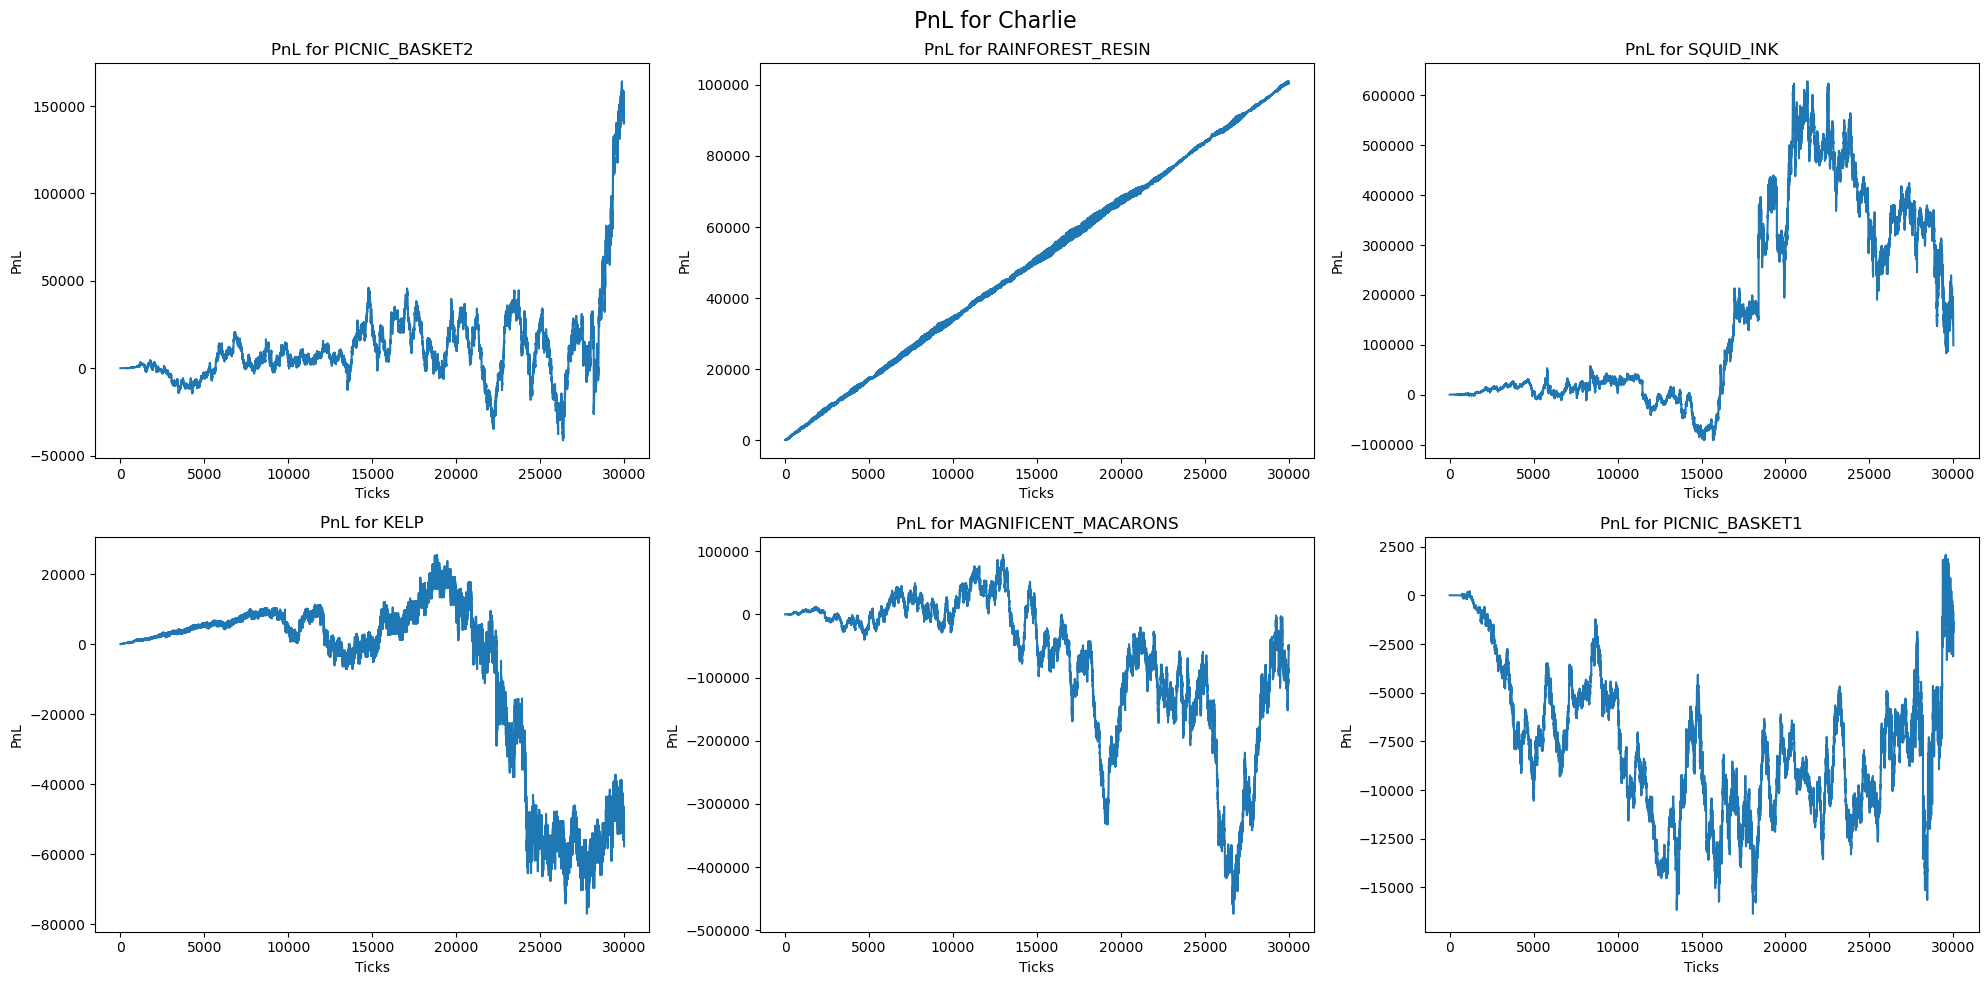

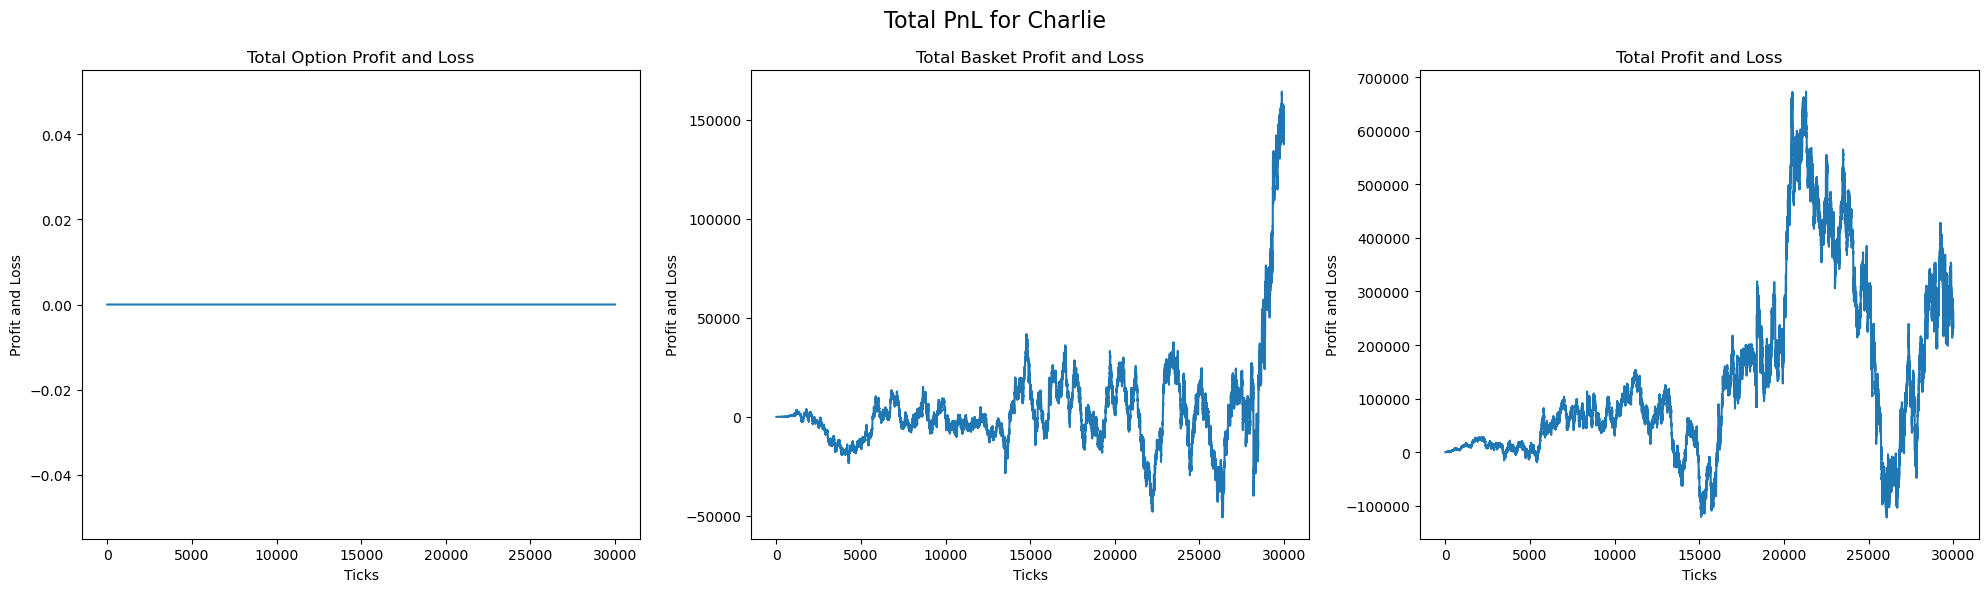

In [221]:
name = "Charlie"
trader_log, snapshot = get_trader_log(trades, prices, name)
plot_pnl(snapshot, products, name)

Check correctness

In [211]:
test = snapshot[(snapshot["product"] == "SQUID_INK") & (~snapshot["price"].isnull())].copy()


In [212]:
test["maker_flag"].value_counts()

maker_flag
1.0    4085
0.0    1542
Name: count, dtype: int64

In [213]:
test.head()

day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
30     2        200  SQUID_INK       1803.0           1.0       1801.0   
54     2        300  SQUID_INK       1801.0          27.0          NaN   
80     2        500  SQUID_INK       1801.0          22.0          NaN   
148    2        900  SQUID_INK       1803.0          21.0          NaN   
230    2       1500  SQUID_INK       1804.0          30.0          NaN   

     bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  ask_volume_2  \
30           32.0          NaN           NaN       1804.0  ...           NaN   
54            NaN          NaN           NaN       1804.0  ...           NaN   
80            NaN          NaN           NaN       1804.0  ...           NaN   
148           NaN          NaN           NaN       1806.0  ...           NaN   
230           NaN          NaN           NaN       1807.0  ...           NaN   

     ask_price_3  ask_volume_3  mid_price  profit_and_loss  quantity  \
30           NaN           NaN     1803.5             -0.5      -1.0   
54           NaN           NaN     1802.5              2.0       1.0   
80           NaN           NaN     1802.5              5.0      -2.0   
148          NaN           NaN     1804.5             13.0       8.0   
230          NaN           NaN     1805.5             20.5       1.0   

     trade_value   price  position  maker_flag  
30       -1803.0  1803.0      -1.0         0.0  
54        1801.0  1801.0       0.0         1.0  
80       -3608.0  1804.0      -2.0         1.0  
148      14424.0  1803.0       6.0         1.0  
230       1804.0  1804.0       7.0         1.0  

[5 rows x 22 columns]

In [214]:
trader_log[trader_log["product"] == "SQUID_INK"].head()

day  timestamp    product  quantity  trade_value   price  position
2     2        200  SQUID_INK        -1      -1803.0  1803.0        -1
4     2        300  SQUID_INK         1       1801.0  1801.0         0
6     2        500  SQUID_INK        -2      -3608.0  1804.0        -2
10    2        900  SQUID_INK         8      14424.0  1803.0         6
12    2       1500  SQUID_INK         1       1804.0  1804.0         7

The position and pnl calculation is correct

In [215]:
snapshot.groupby("product")["maker_flag"].value_counts()

product               maker_flag
KELP                  1.0           4012
                      0.0           1596
MAGNIFICENT_MACARONS  1.0            399
PICNIC_BASKET1        1.0             26
PICNIC_BASKET2        1.0            338
RAINFOREST_RESIN      1.0           2703
                      0.0           1516
SQUID_INK             1.0           4085
                      0.0           1542
Name: count, dtype: int64

In [216]:
test.head(20)

day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
30      2        200  SQUID_INK       1803.0           1.0       1801.0   
54      2        300  SQUID_INK       1801.0          27.0          NaN   
80      2        500  SQUID_INK       1801.0          22.0          NaN   
148     2        900  SQUID_INK       1803.0          21.0          NaN   
230     2       1500  SQUID_INK       1804.0          30.0          NaN   
314     2       2000  SQUID_INK       1805.0          22.0          NaN   
532     2       3500  SQUID_INK       1806.0          23.0          NaN   
562     2       3700  SQUID_INK       1806.0          25.0          NaN   
699     2       4600  SQUID_INK       1804.0           1.0       1802.0   
707     2       4700  SQUID_INK       1802.0          35.0          NaN   
749     2       4900  SQUID_INK       1803.0          29.0          NaN   
869     2       5700  SQUID_INK       1805.0          37.0          NaN   
875     2       5800  SQUID_INK       1805.0           9.0       1804.0   
893     2       5900  SQUID_INK       1807.0           4.0       1806.0   
1111    2       7400  SQUID_INK       1807.0          27.0          NaN   
1177    2       7800  SQUID_INK       1810.0           1.0       1808.0   
1424    2       9400  SQUID_INK       1808.0          30.0          NaN   
1498    2       9900  SQUID_INK       1805.0          31.0          NaN   
1755    2      11700  SQUID_INK       1799.0          23.0          NaN   
1857    2      12300  SQUID_INK       1802.0          18.0          NaN   

      bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  ask_volume_2  \
30            32.0          NaN           NaN       1804.0  ...           NaN   
54             NaN          NaN           NaN       1804.0  ...           NaN   
80             NaN          NaN           NaN       1804.0  ...           NaN   
148            NaN          NaN           NaN       1806.0  ...           NaN   
230            NaN          NaN           NaN       1807.0  ...           NaN   
314            NaN          NaN           NaN       1806.0  ...          22.0   
532            NaN          NaN           NaN       1807.0  ...          23.0   
562            NaN          NaN           NaN       1807.0  ...           2.0   
699           22.0          NaN           NaN       1805.0  ...           NaN   
707            NaN          NaN           NaN       1805.0  ...           NaN   
749            NaN          NaN           NaN       1806.0  ...           NaN   
869            NaN          NaN           NaN       1808.0  ...           NaN   
875           28.0          NaN           NaN       1808.0  ...           NaN   
893            2.0       1805.0          29.0       1809.0  ...           NaN   
1111           NaN          NaN           NaN       1810.0  ...           NaN   
1177          22.0          NaN           NaN       1811.0  ...           NaN   
1424           NaN          NaN           NaN       1809.0  ...          30.0   
1498           NaN          NaN           NaN       1806.0  ...          31.0   
1755           NaN          NaN           NaN       1800.0  ...          23.0   
1857           NaN          NaN           NaN       1805.0  ...           NaN   

      ask_price_3  ask_volume_3  mid_price  profit_and_loss  quantity  \
30            NaN           NaN     1803.5             -0.5      -1.0   
54            NaN           NaN     1802.5              2.0       1.0   
80            NaN           NaN     1802.5              5.0      -2.0   
148           NaN           NaN     1804.5             13.0       8.0   
230           NaN           NaN     1805.5             20.5       1.0   
314           NaN           NaN     1805.5             20.0       1.0   
532           NaN           NaN     1806.5             27.5       1.0   
562        1809.0          25.0     1806.5             25.0       5.0   
699           NaN           NaN     1804.5             -3.5      -1.0  

In [217]:
# import os
# os.makedirs("./trader_logs", exist_ok=True)
# for trader in traders_set:
#     trader_log, snapshot = get_trader_log(trades, prices, trader)
#     snapshot.to_csv(f"./trader_logs/{trader}.csv", sep=";", index=False)
#     print(f"Trader {trader} log saved.")

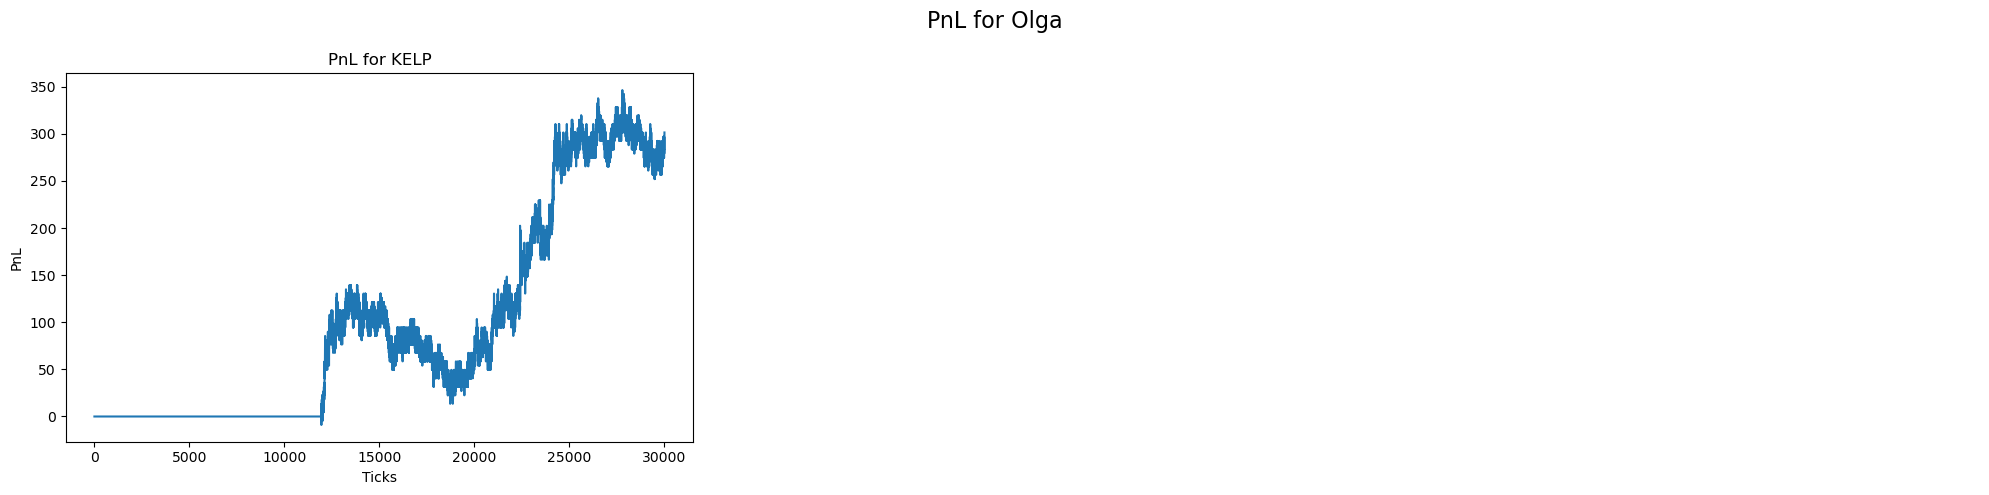

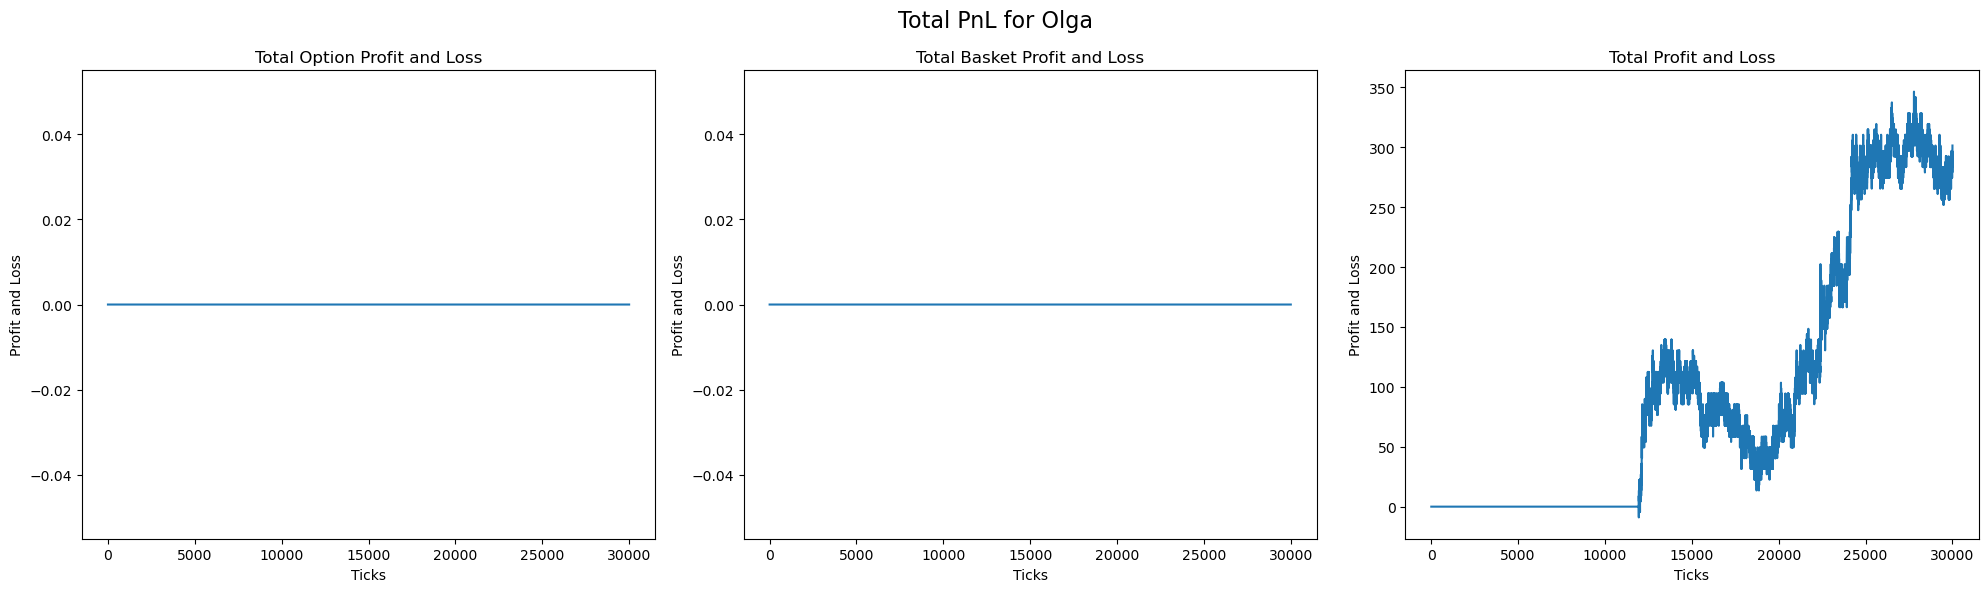

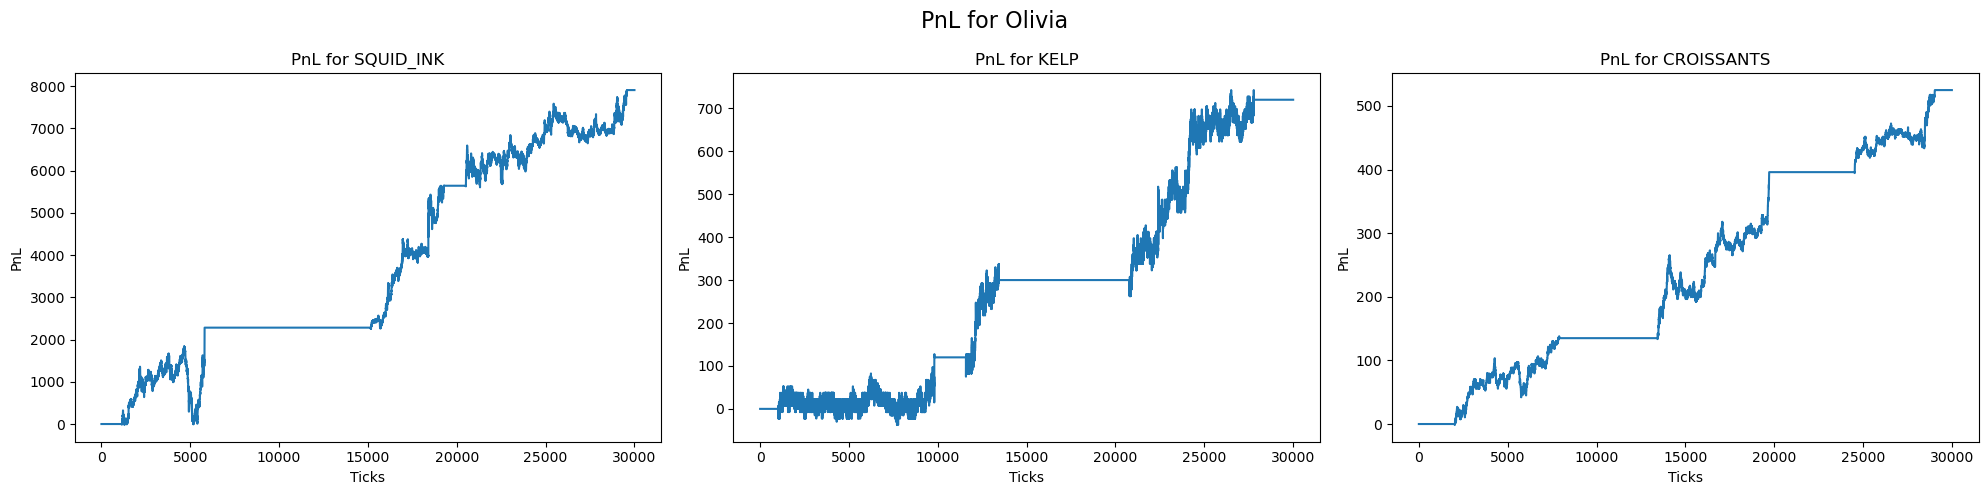

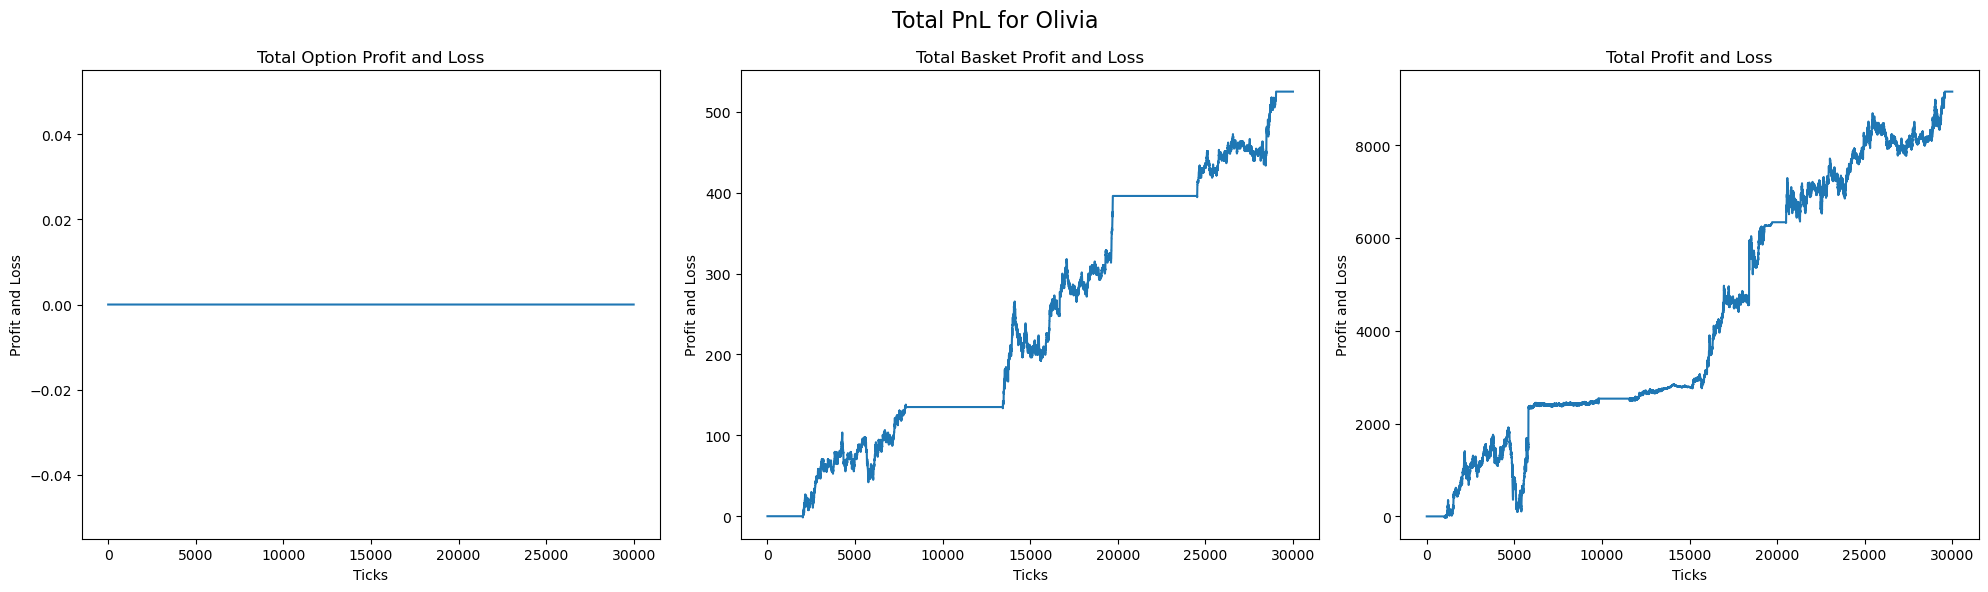

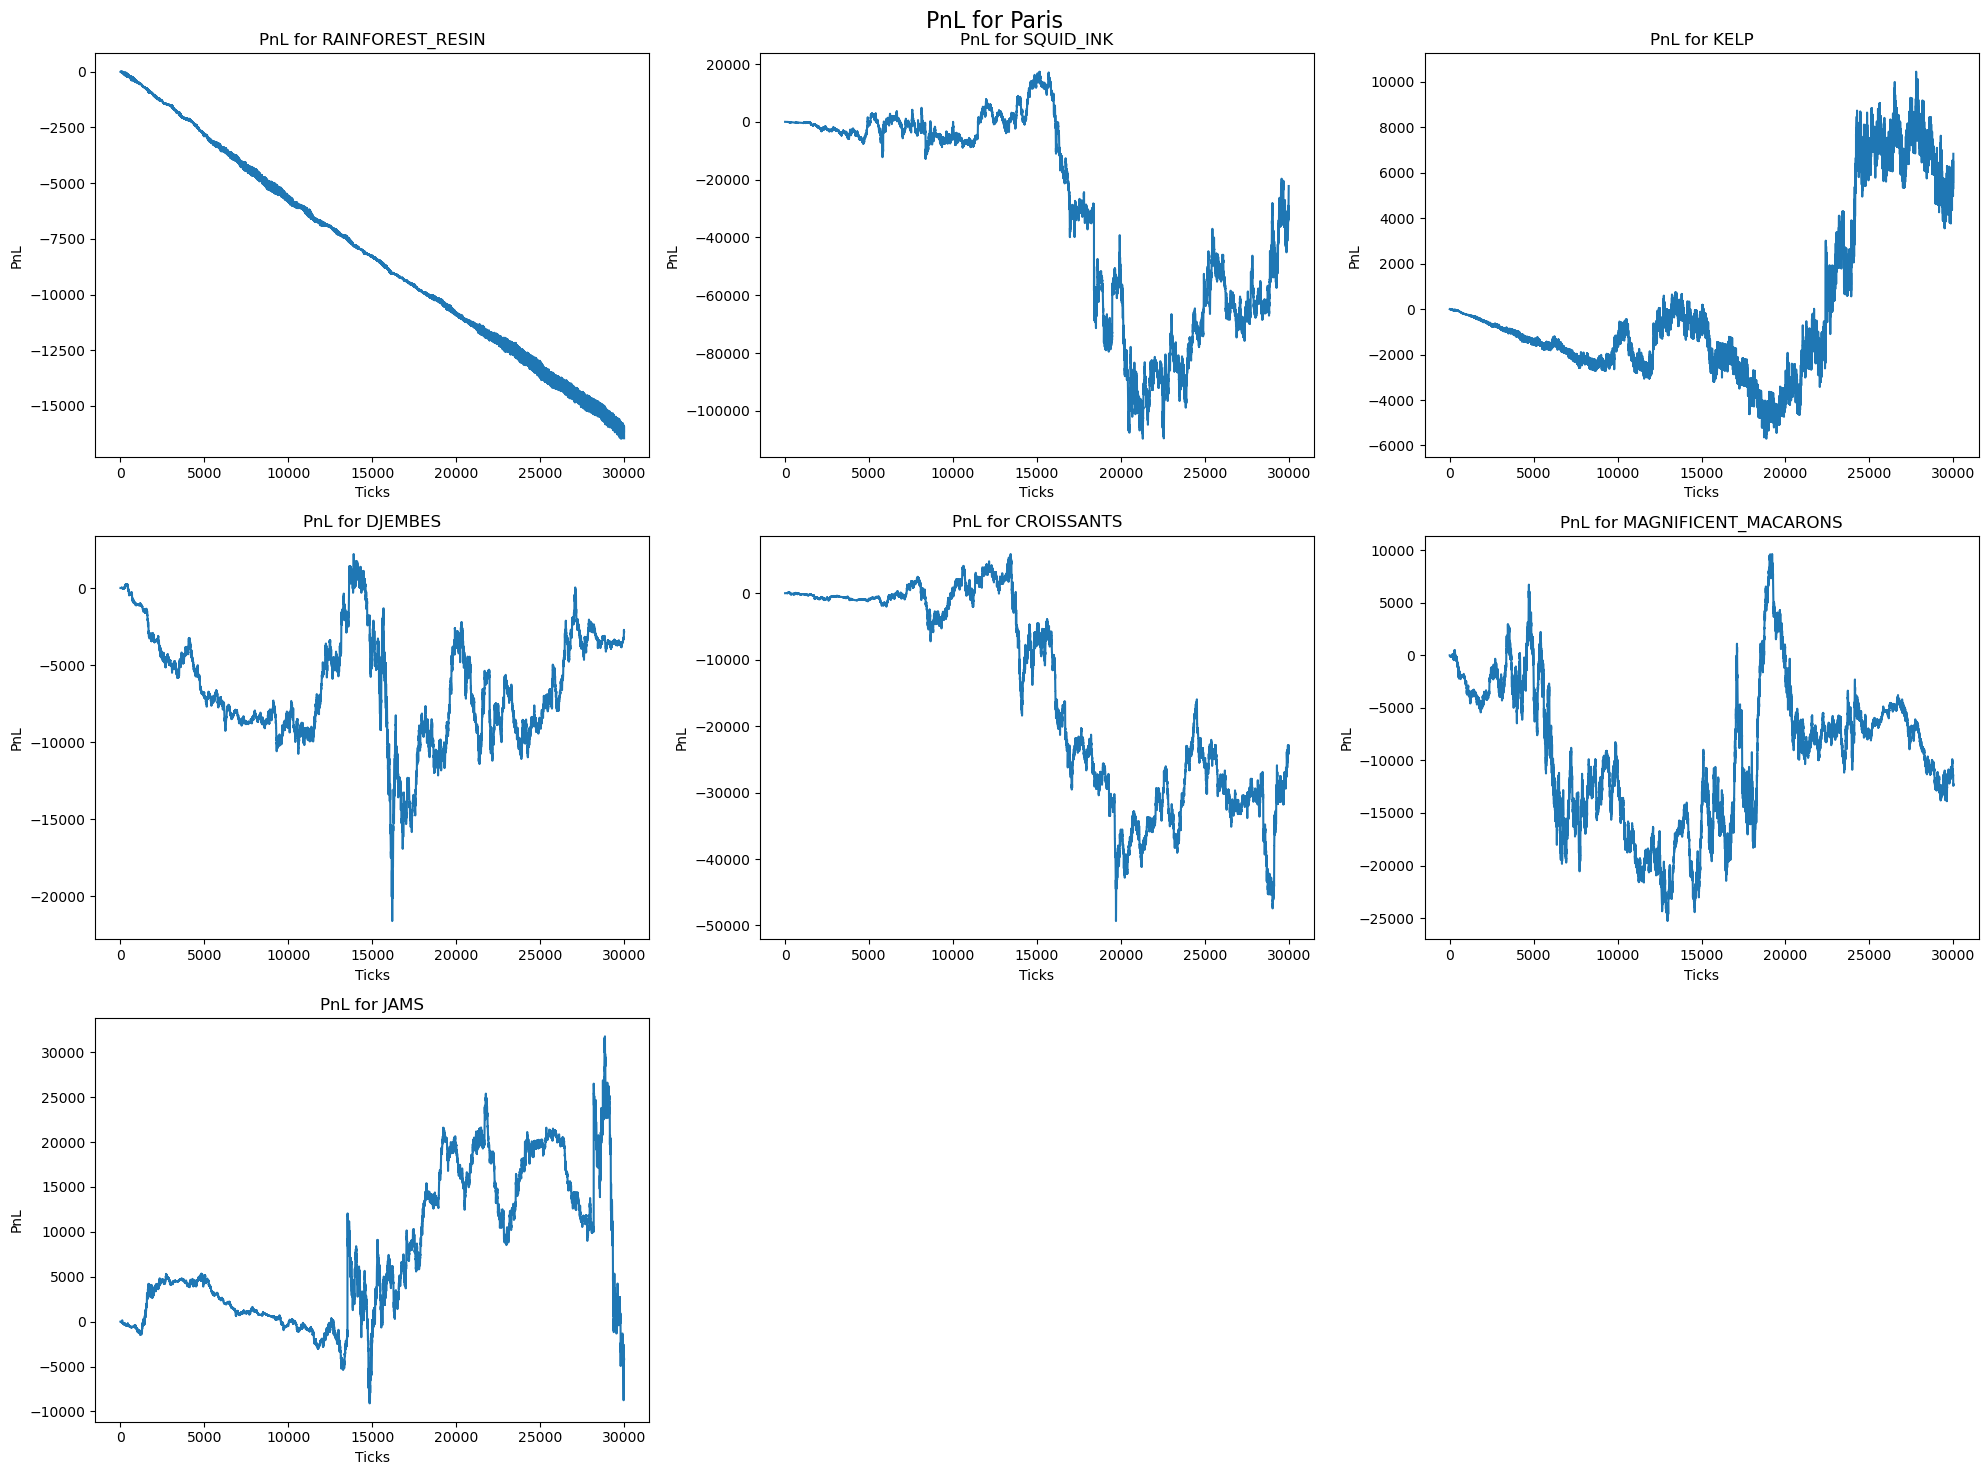

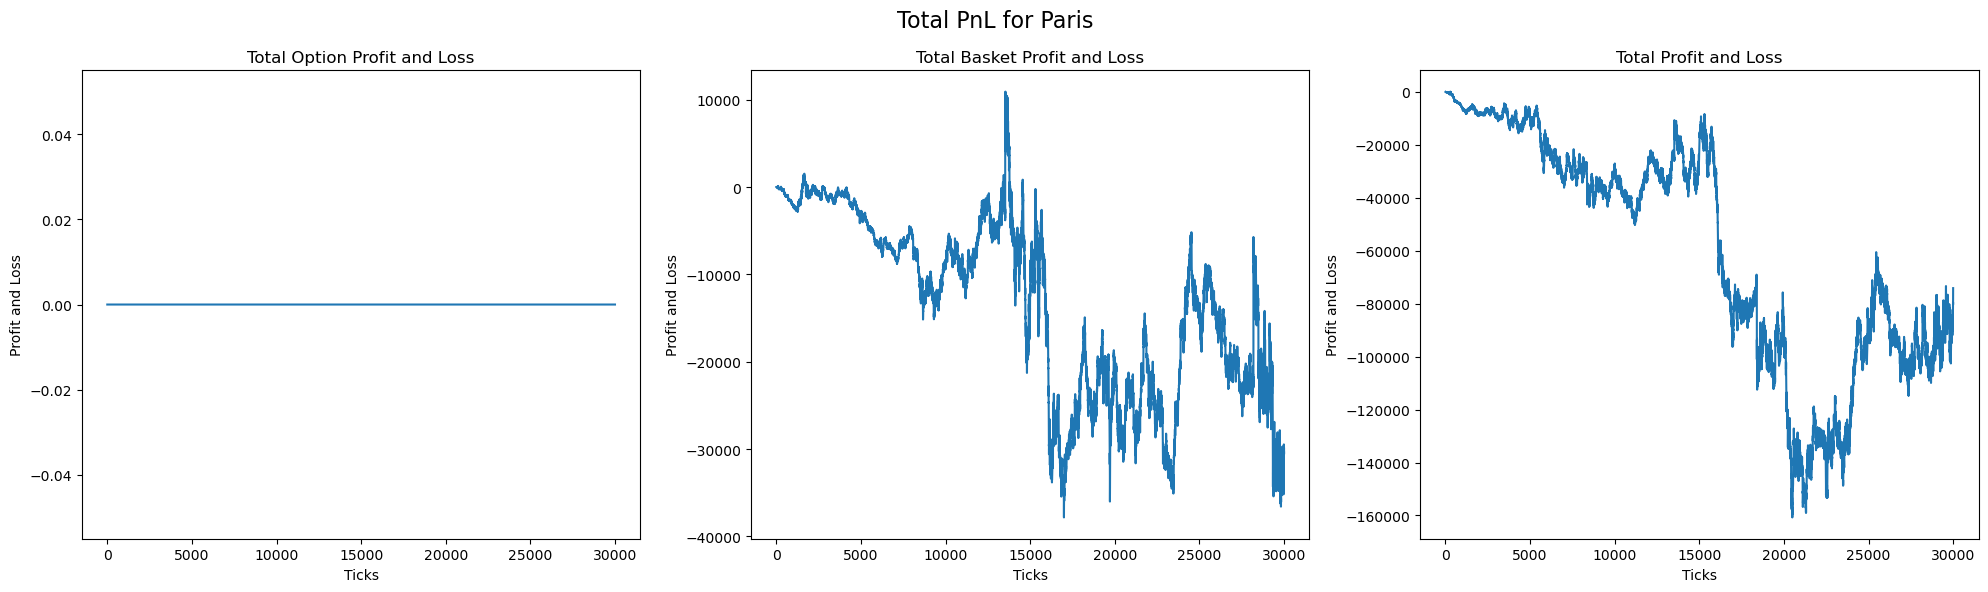

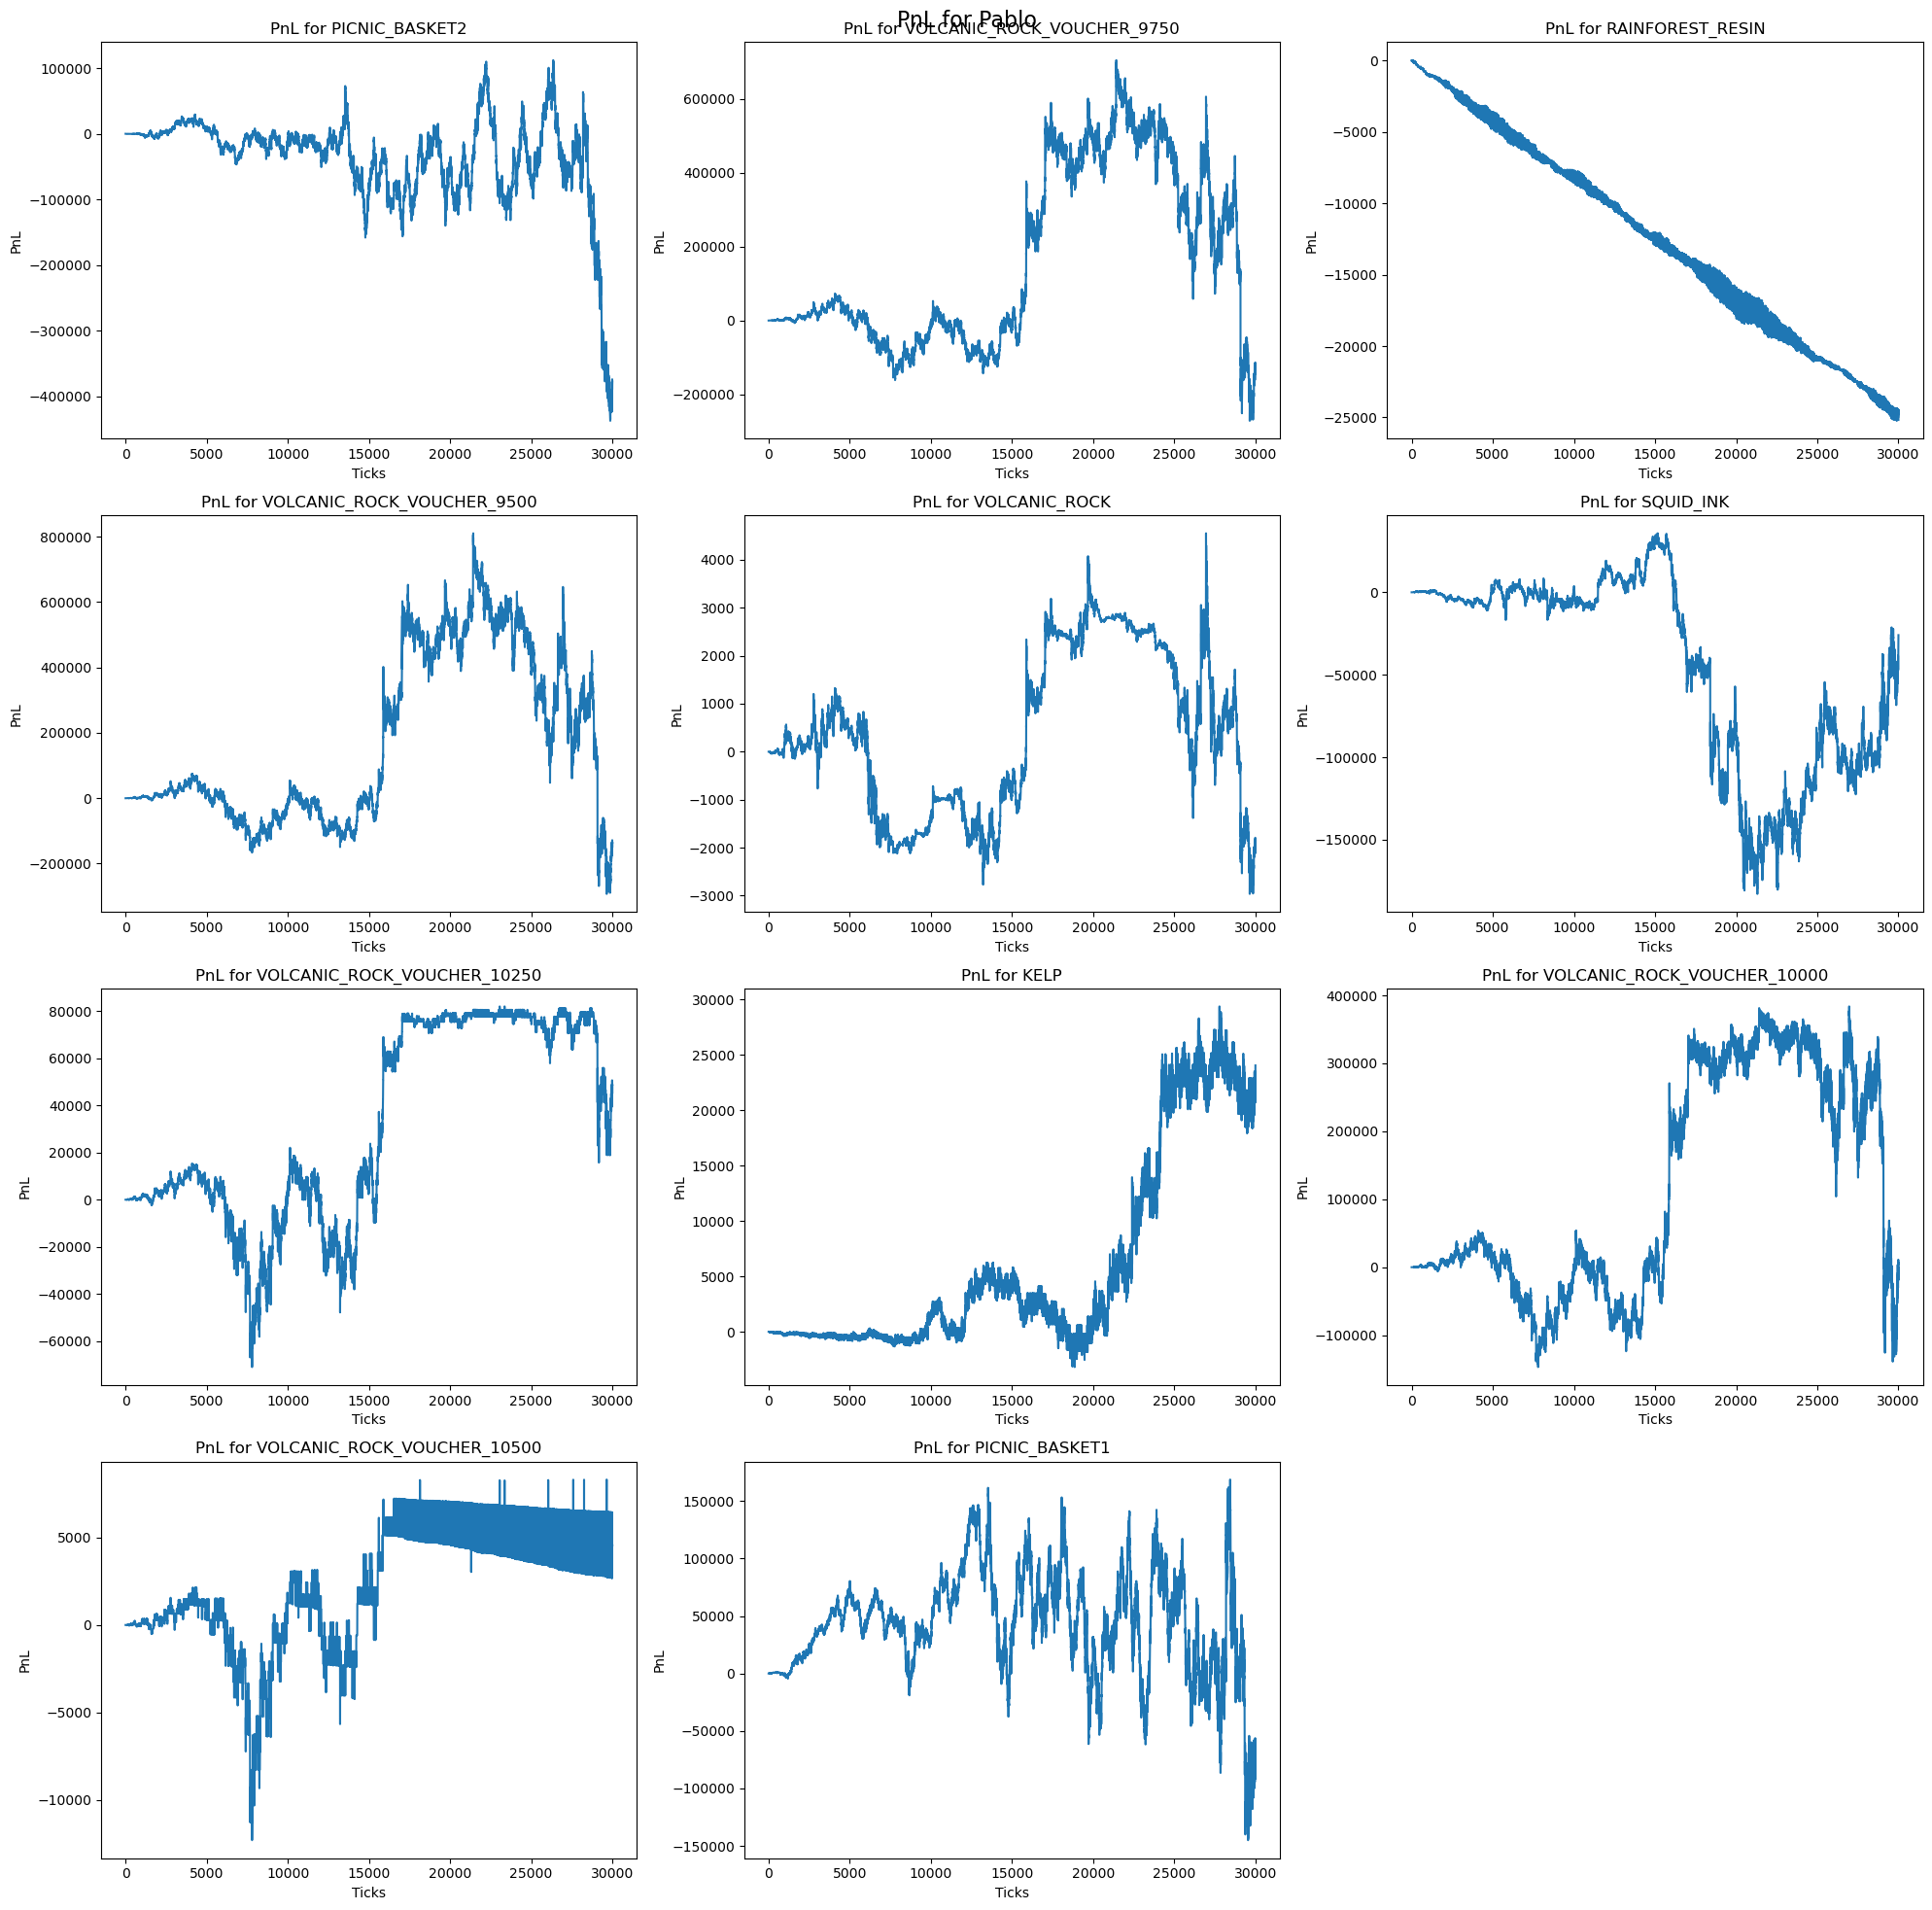

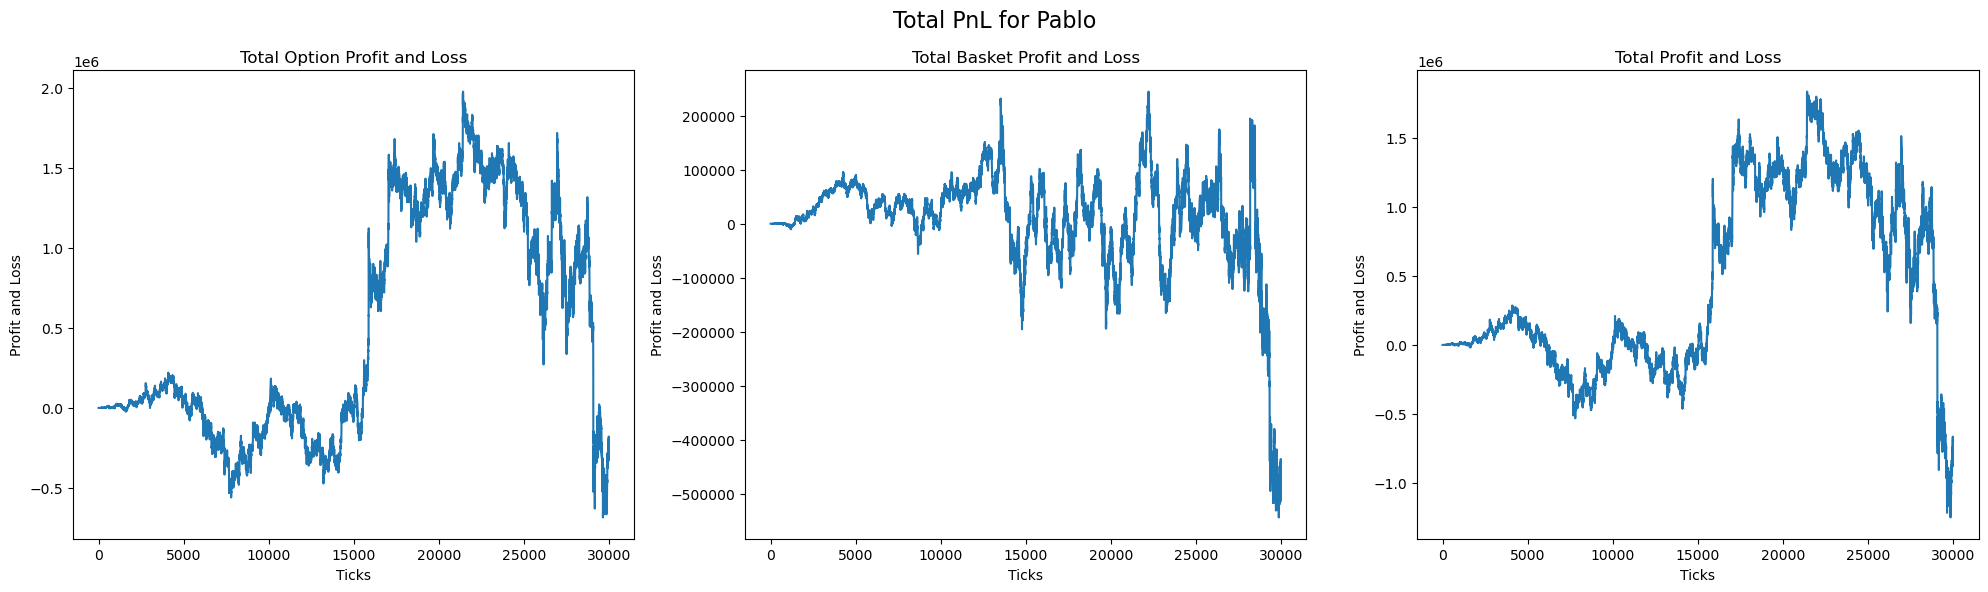

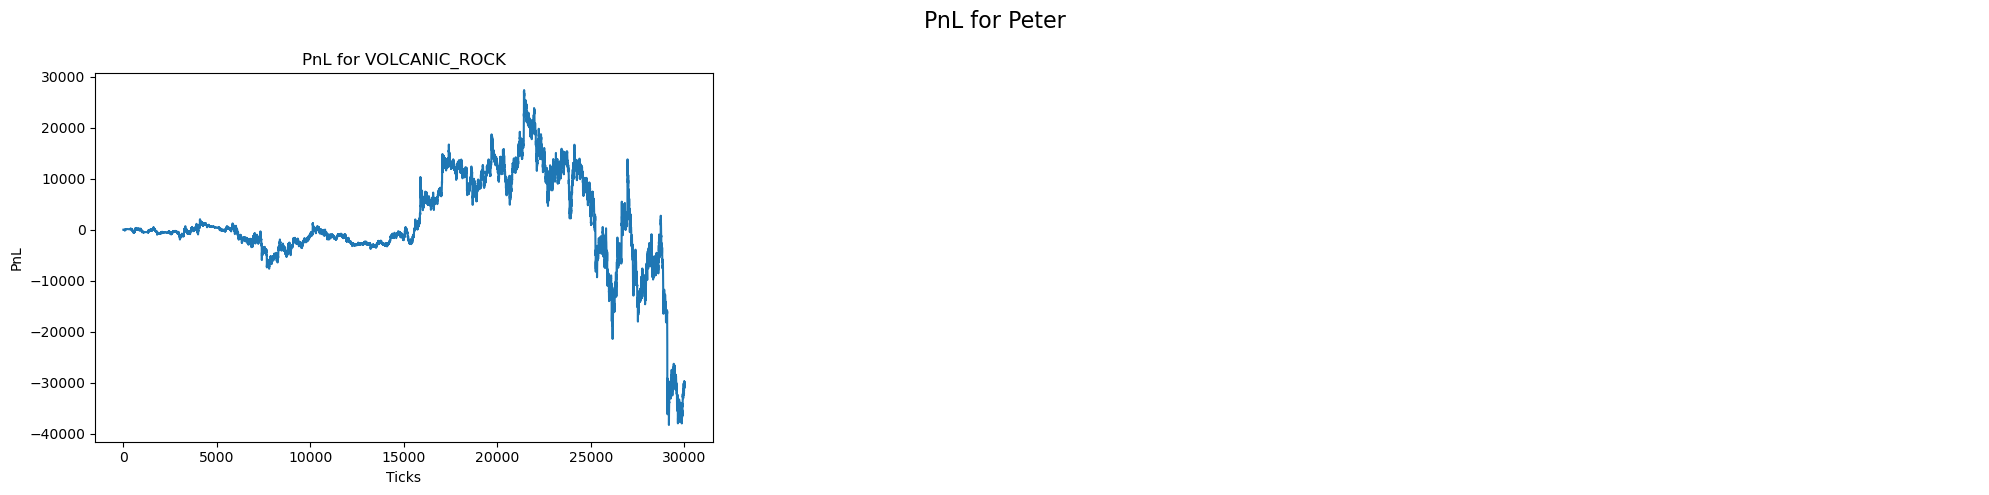

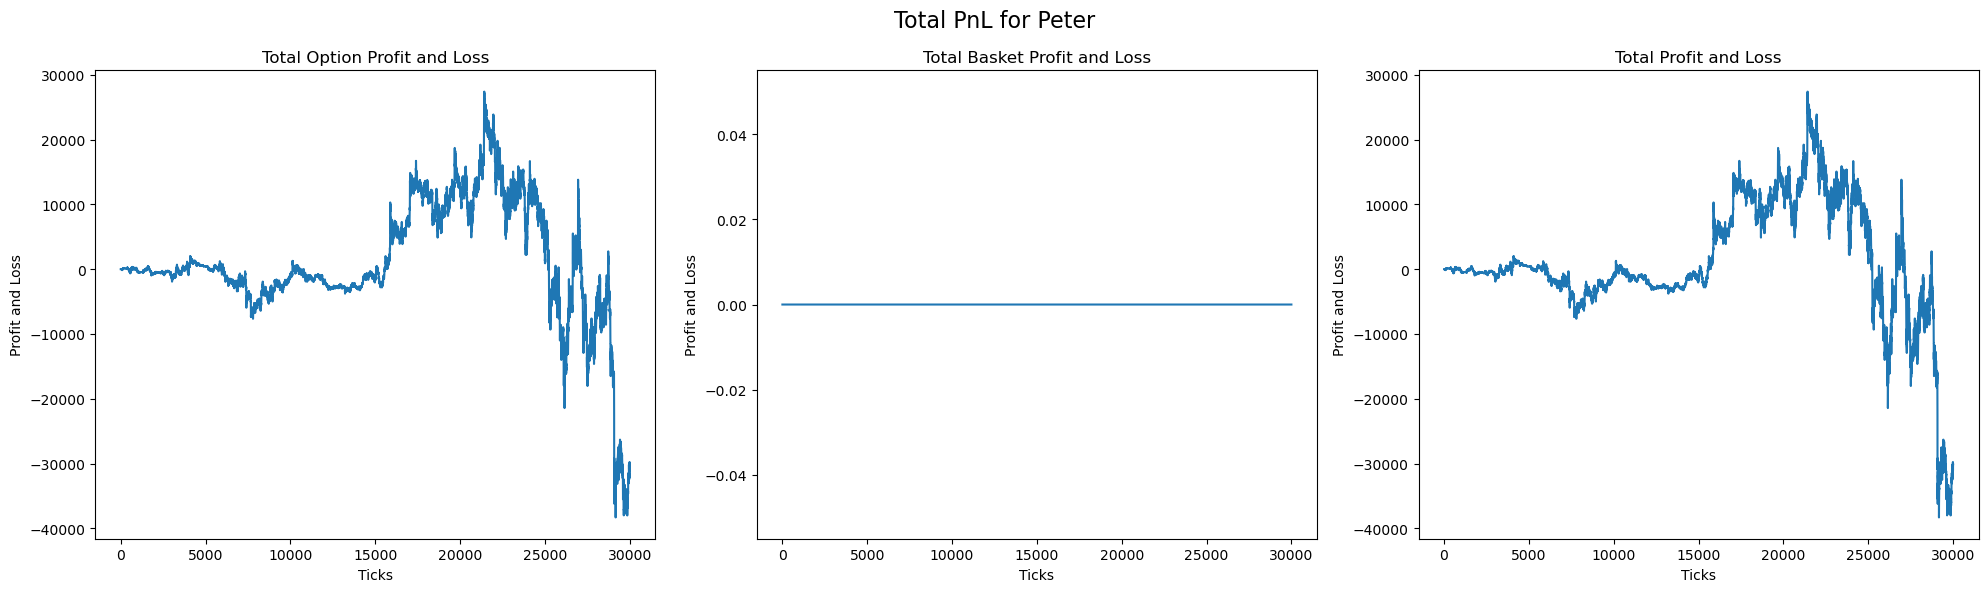

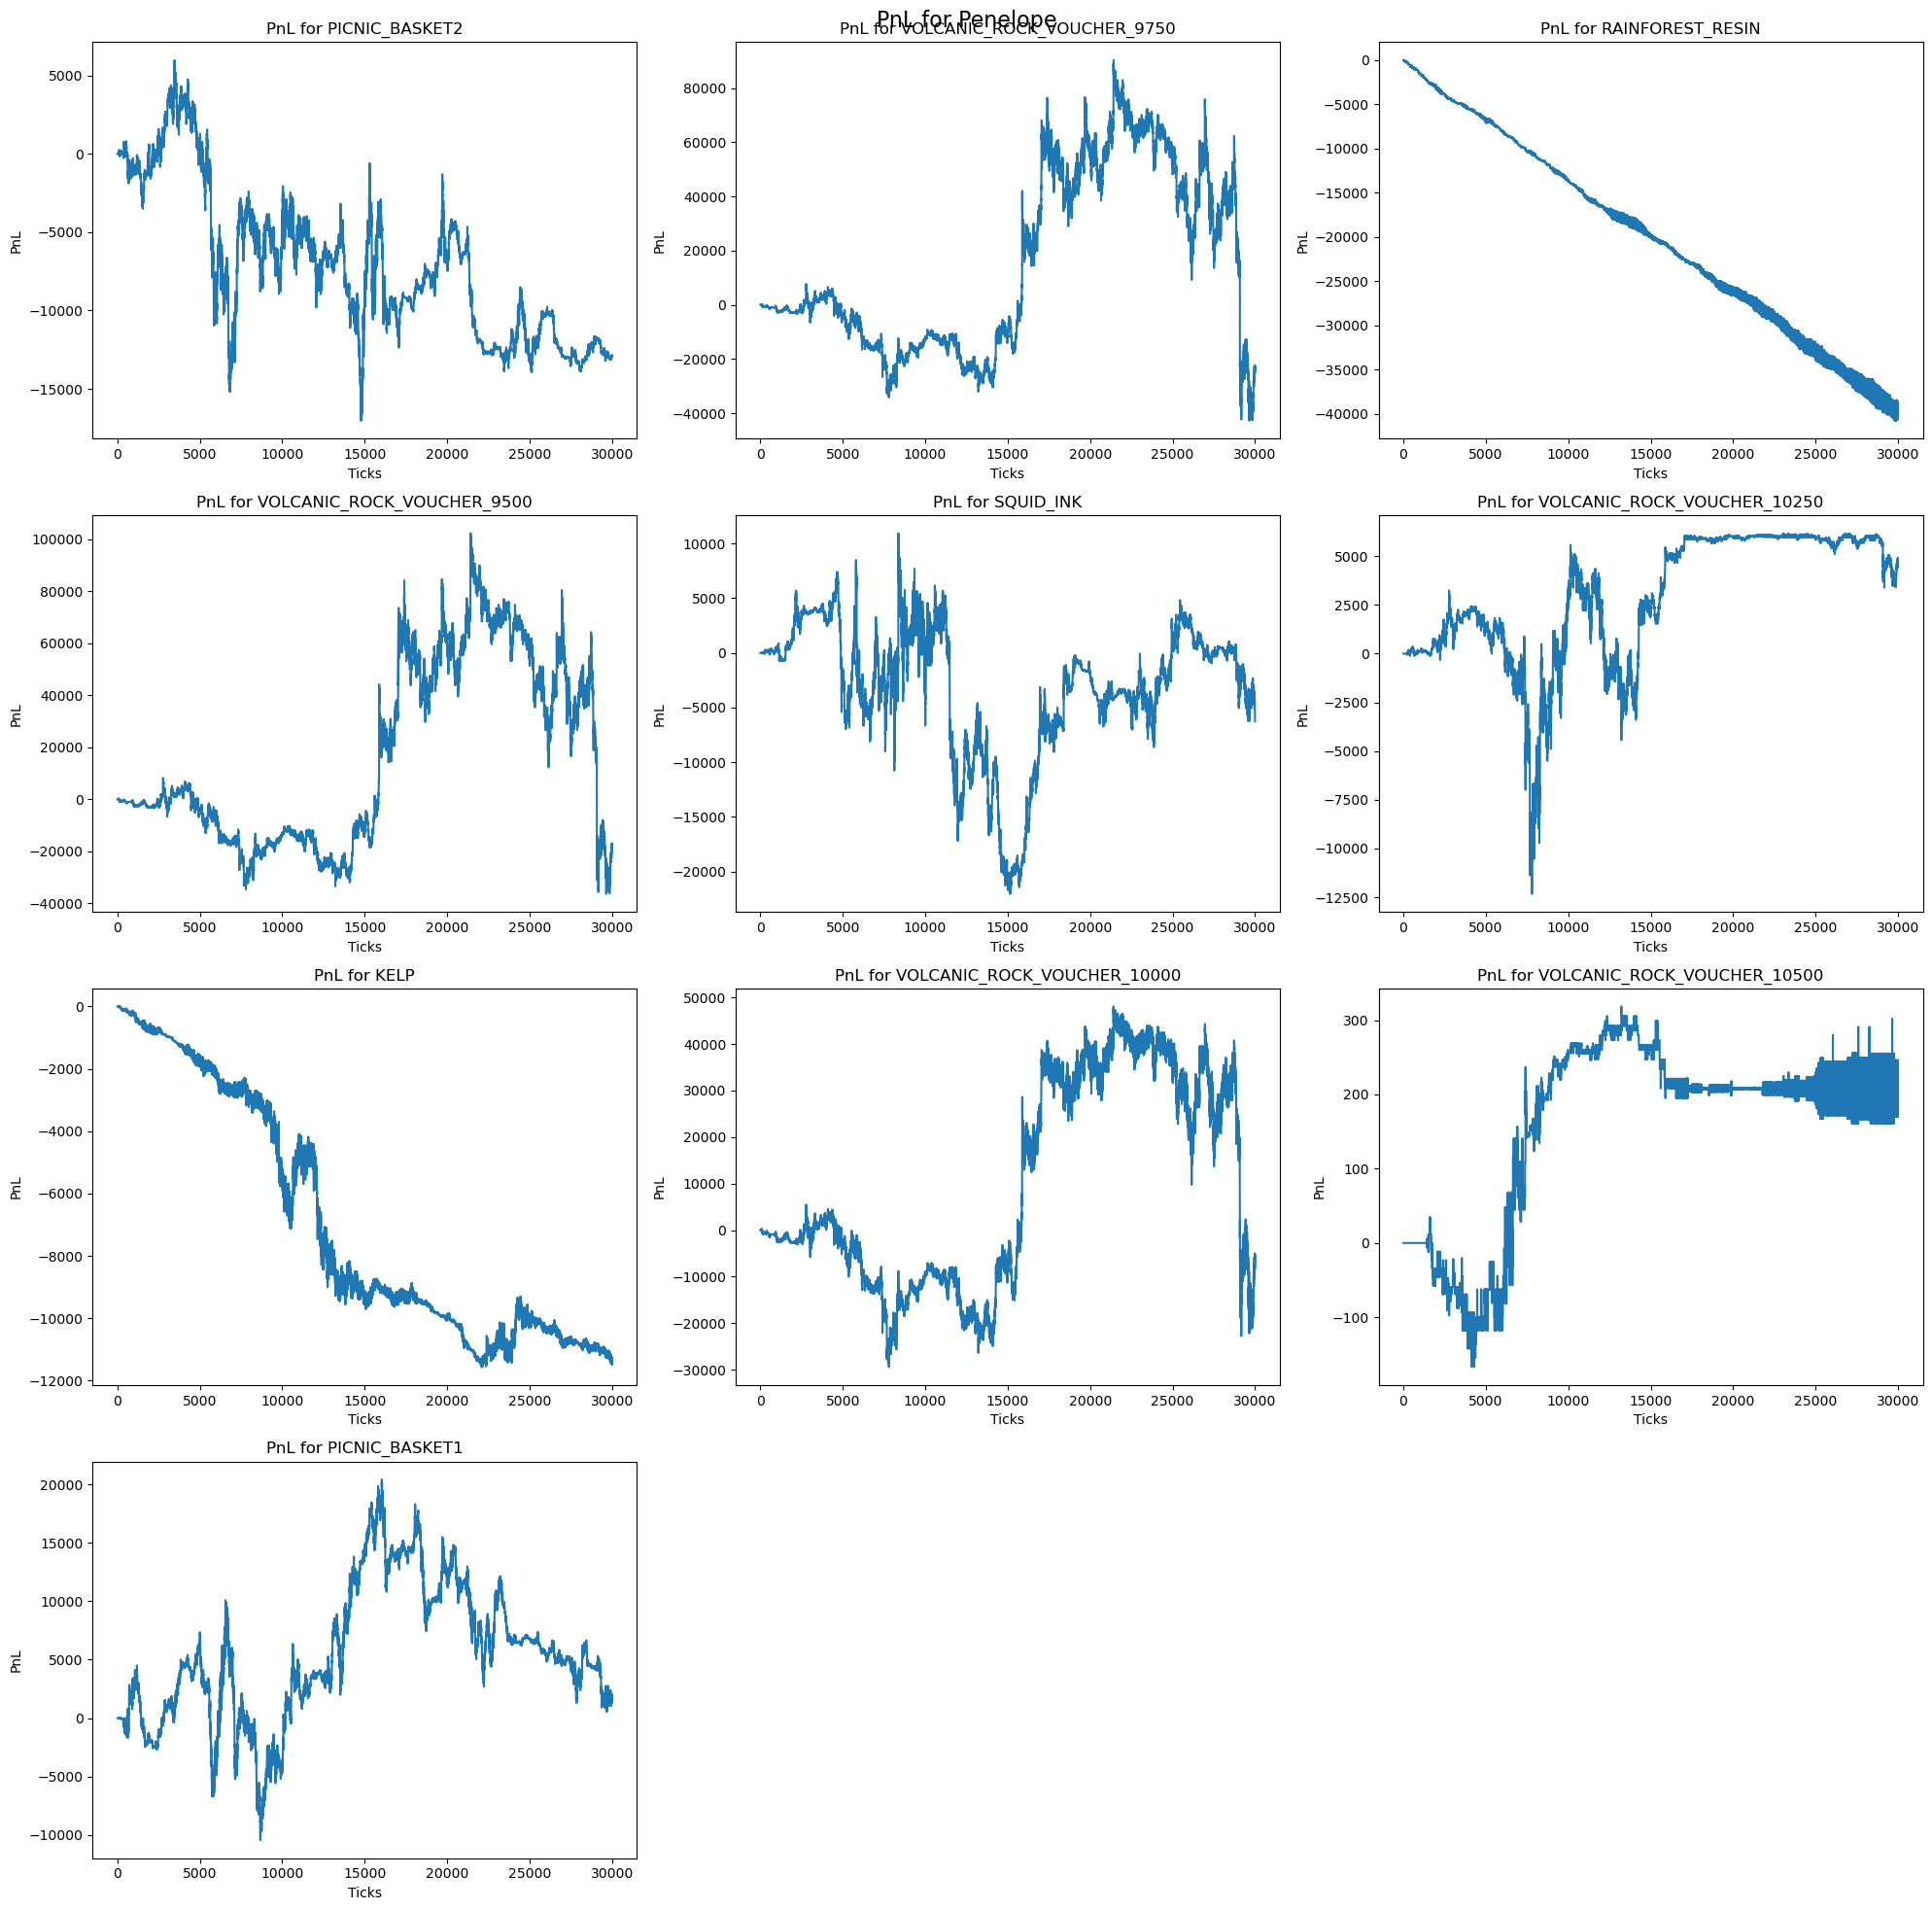

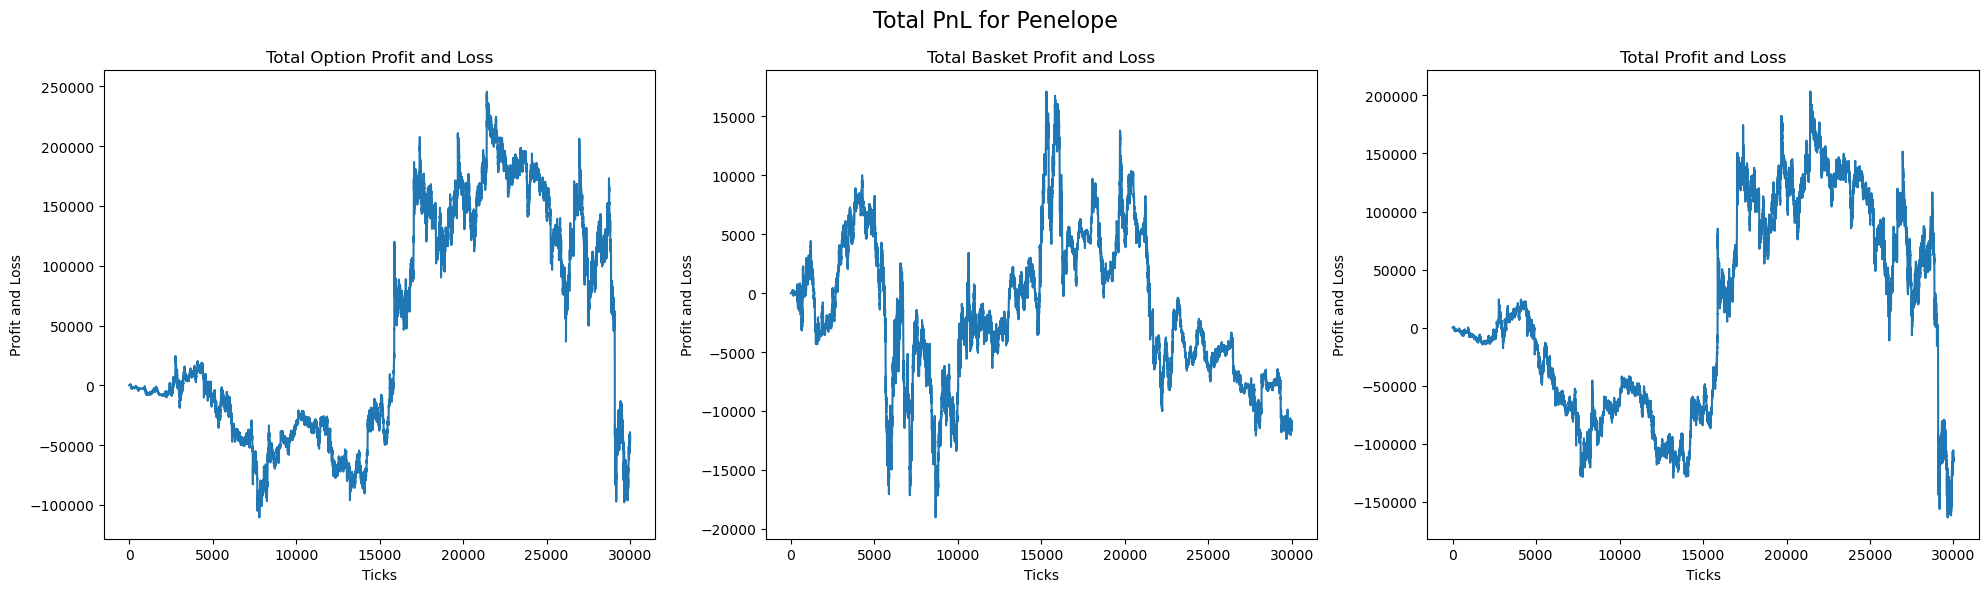

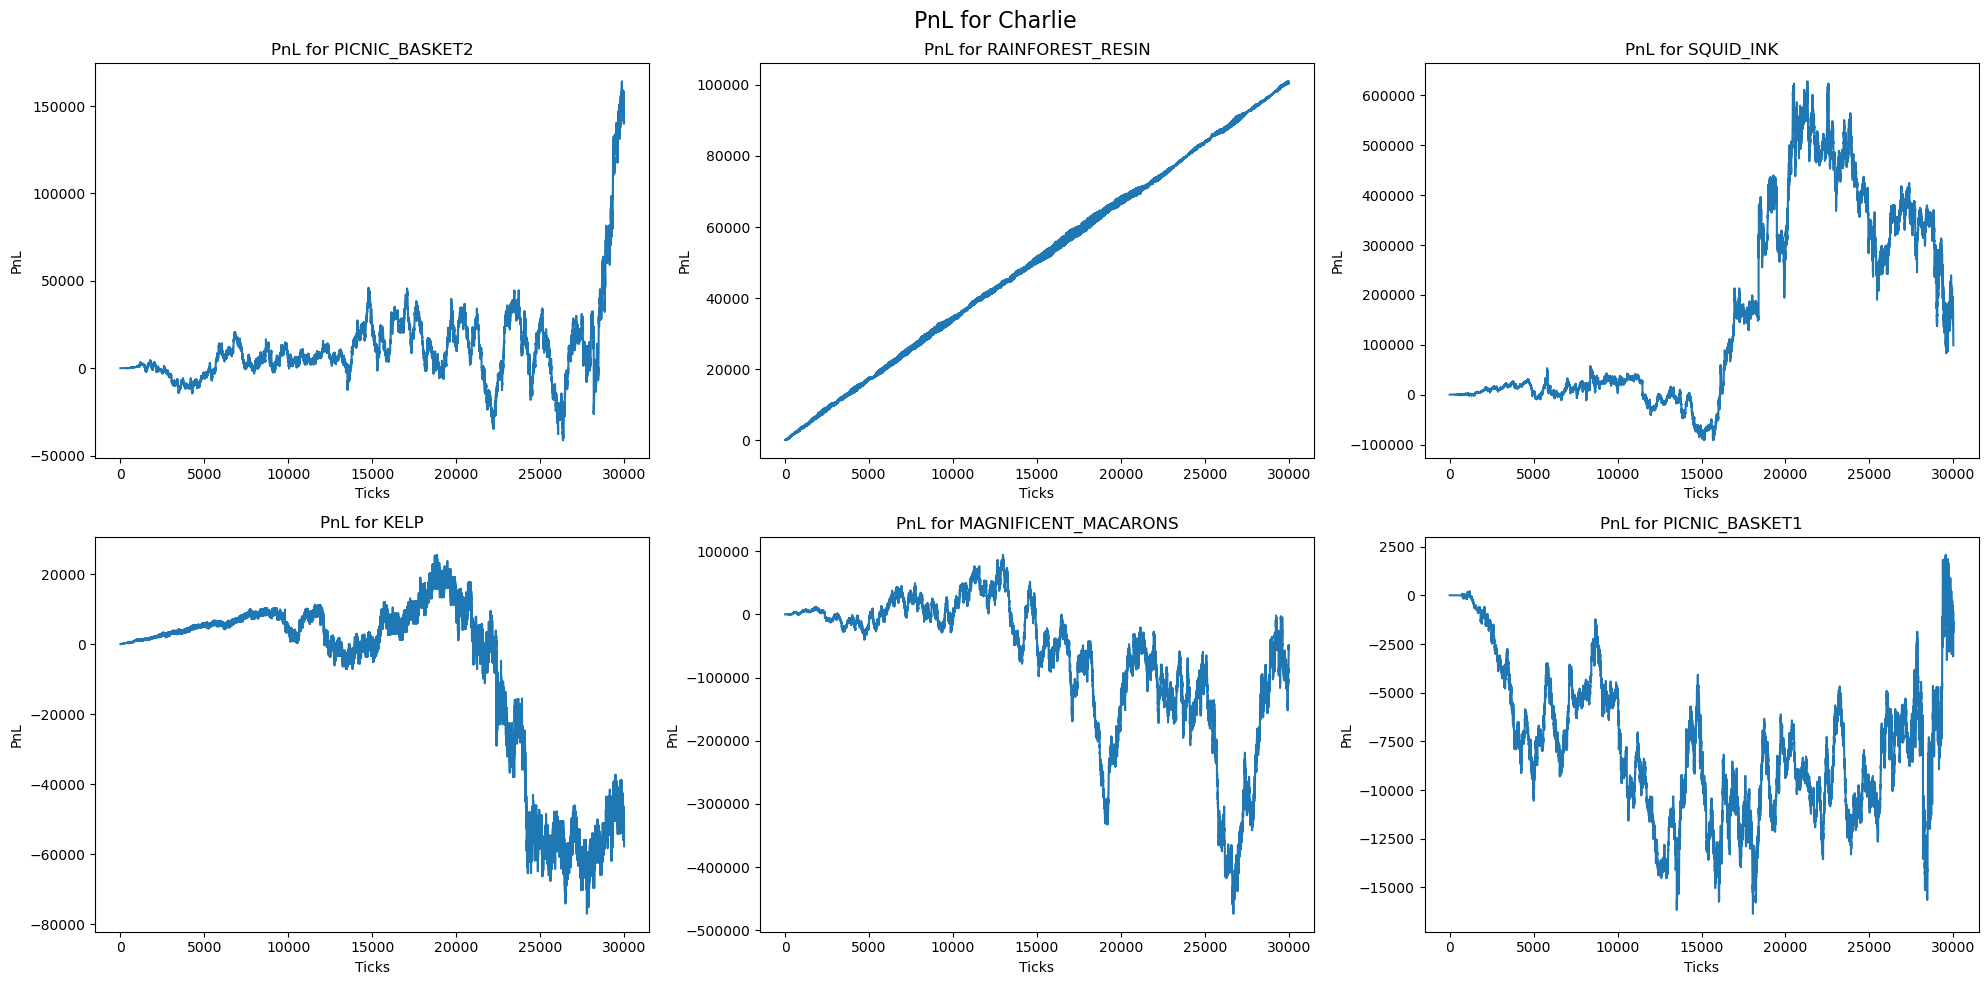

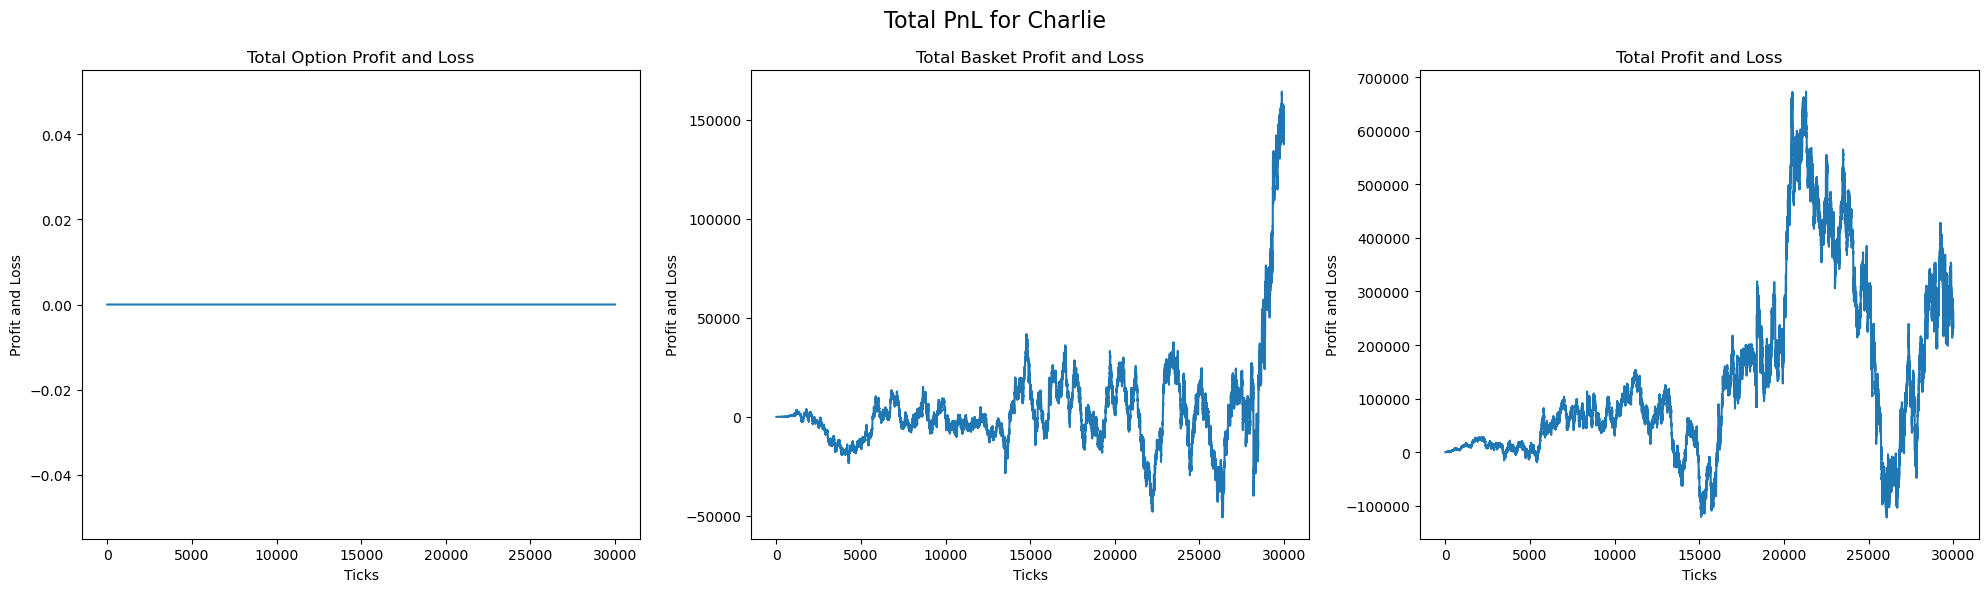

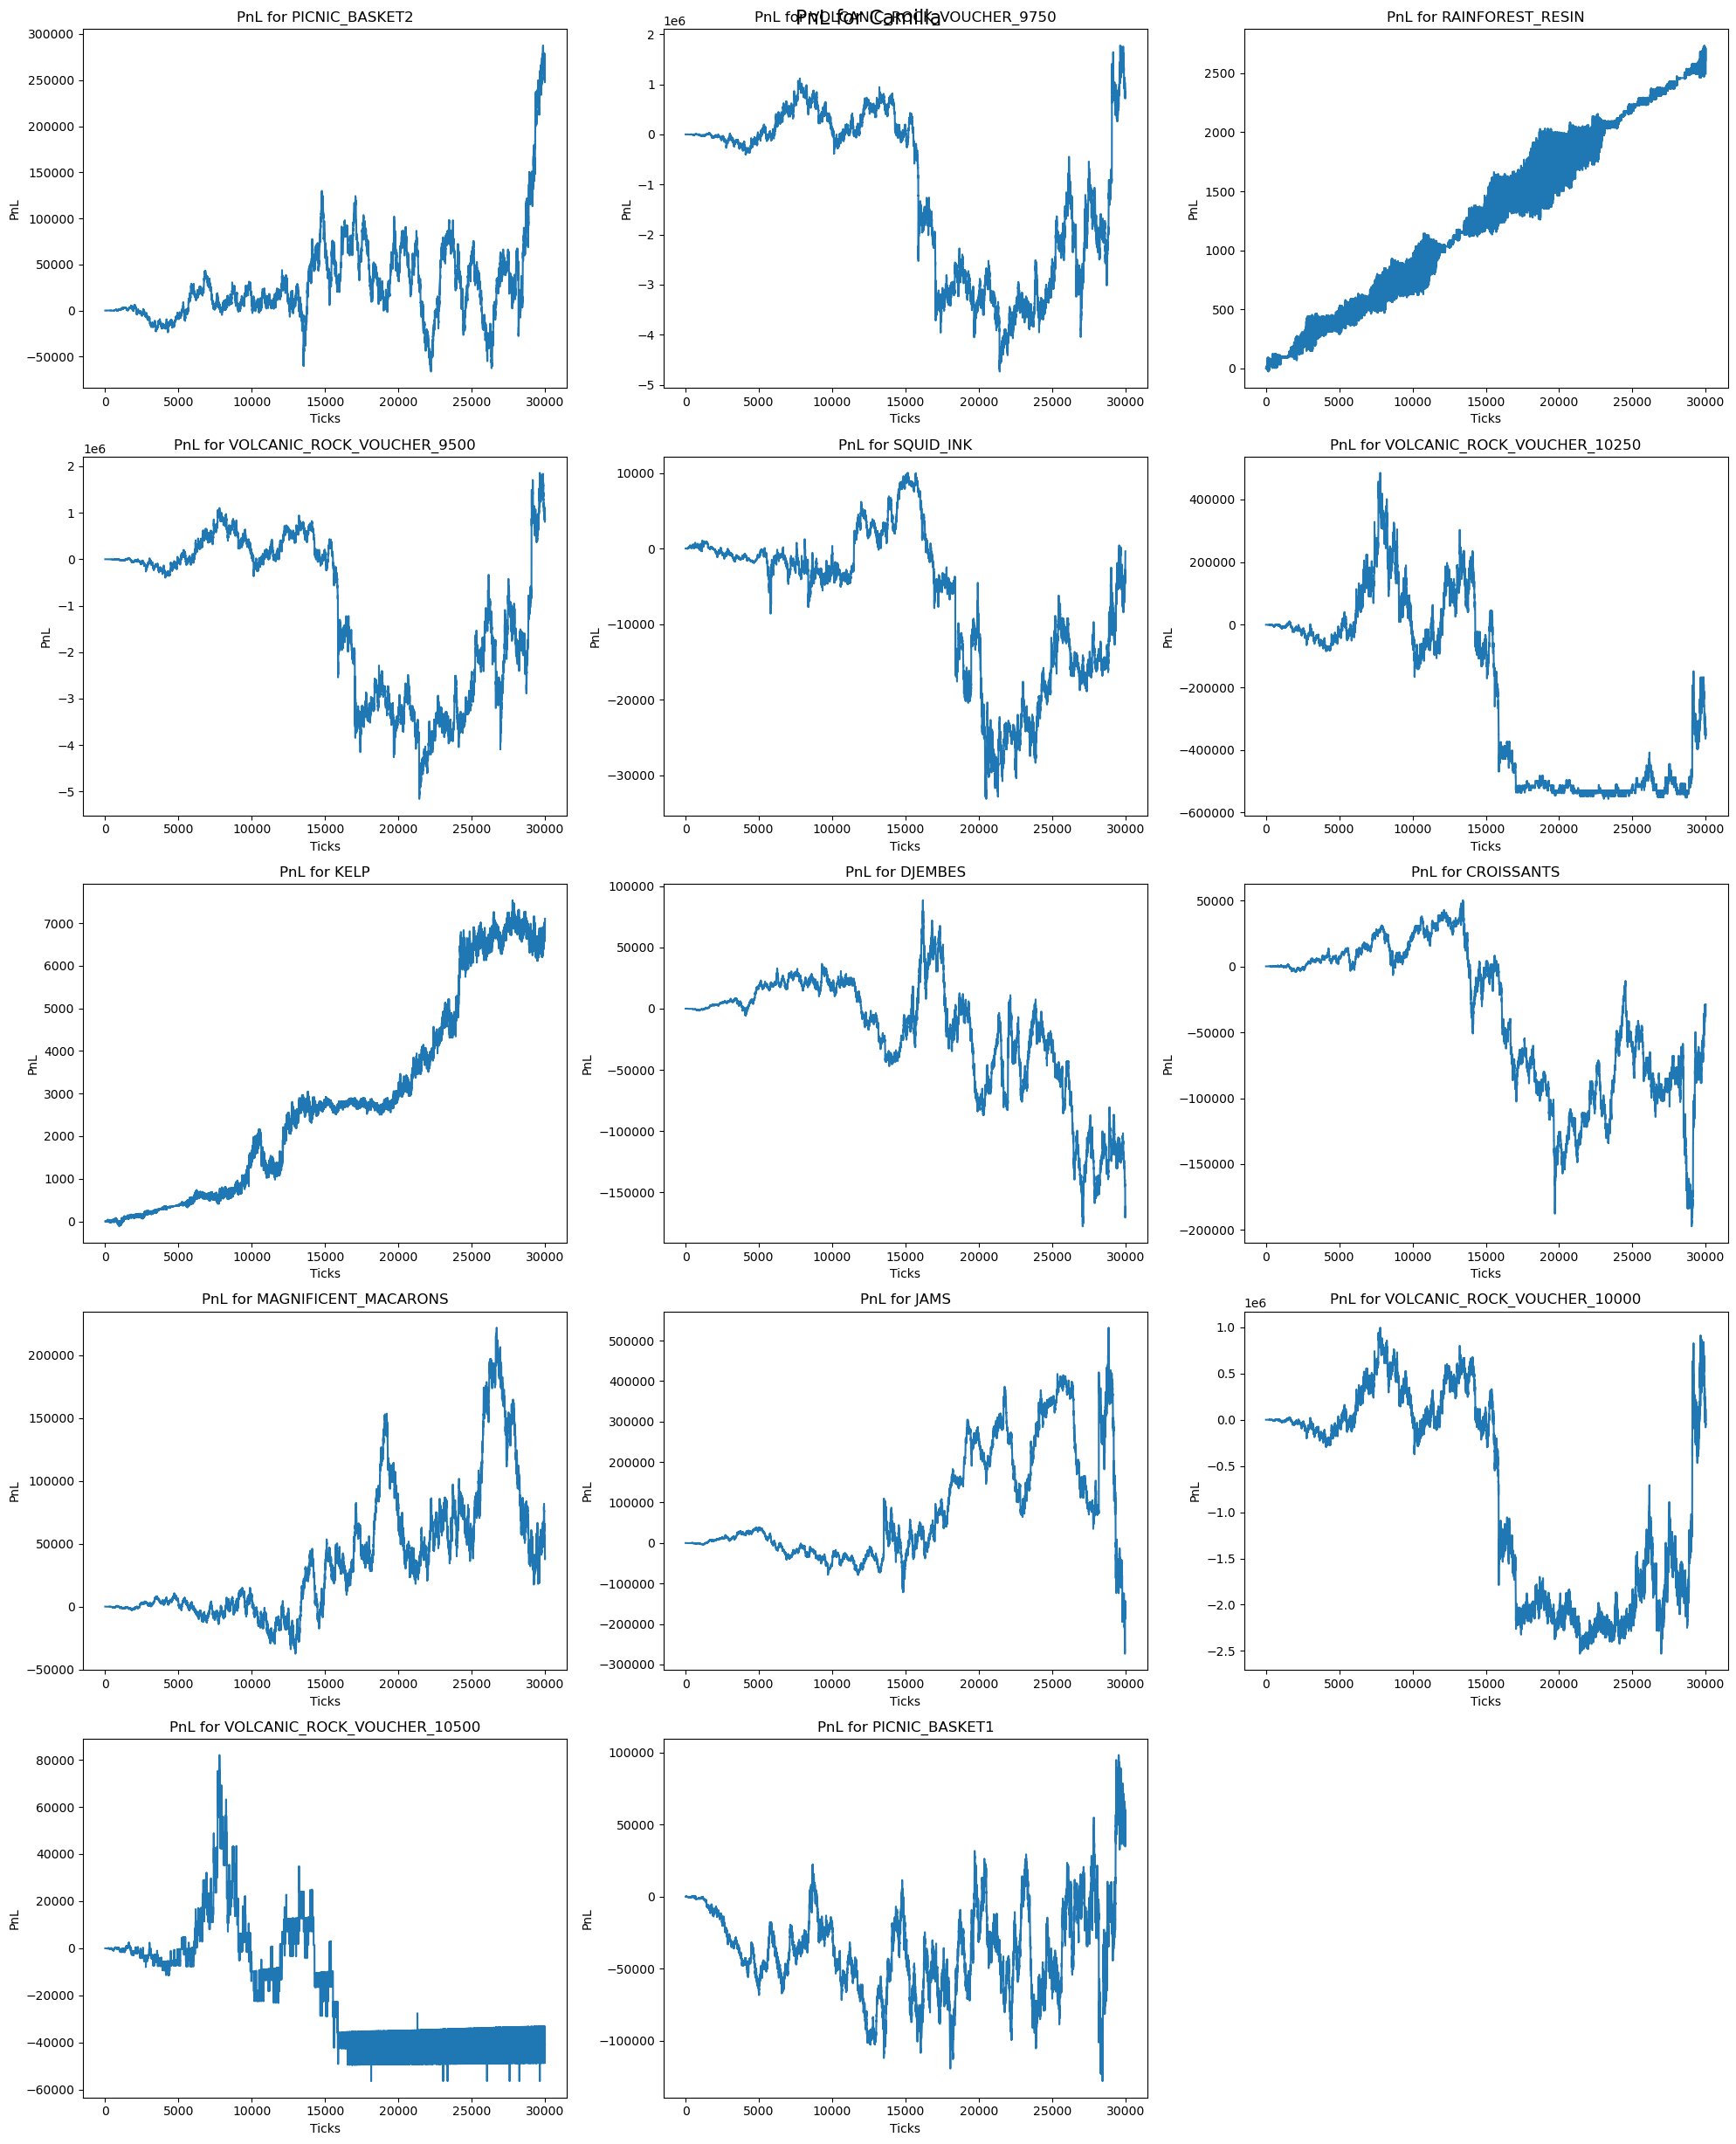

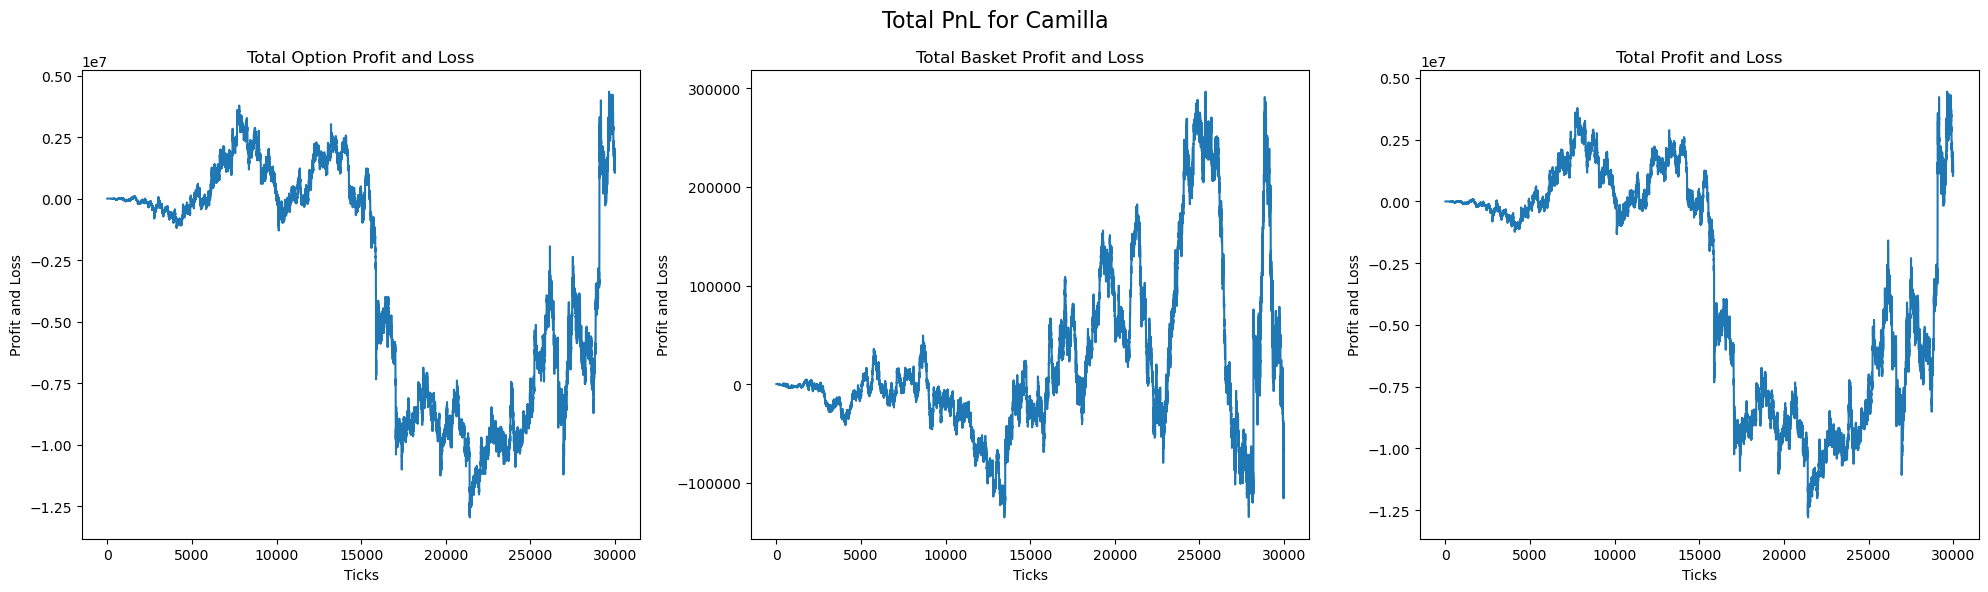

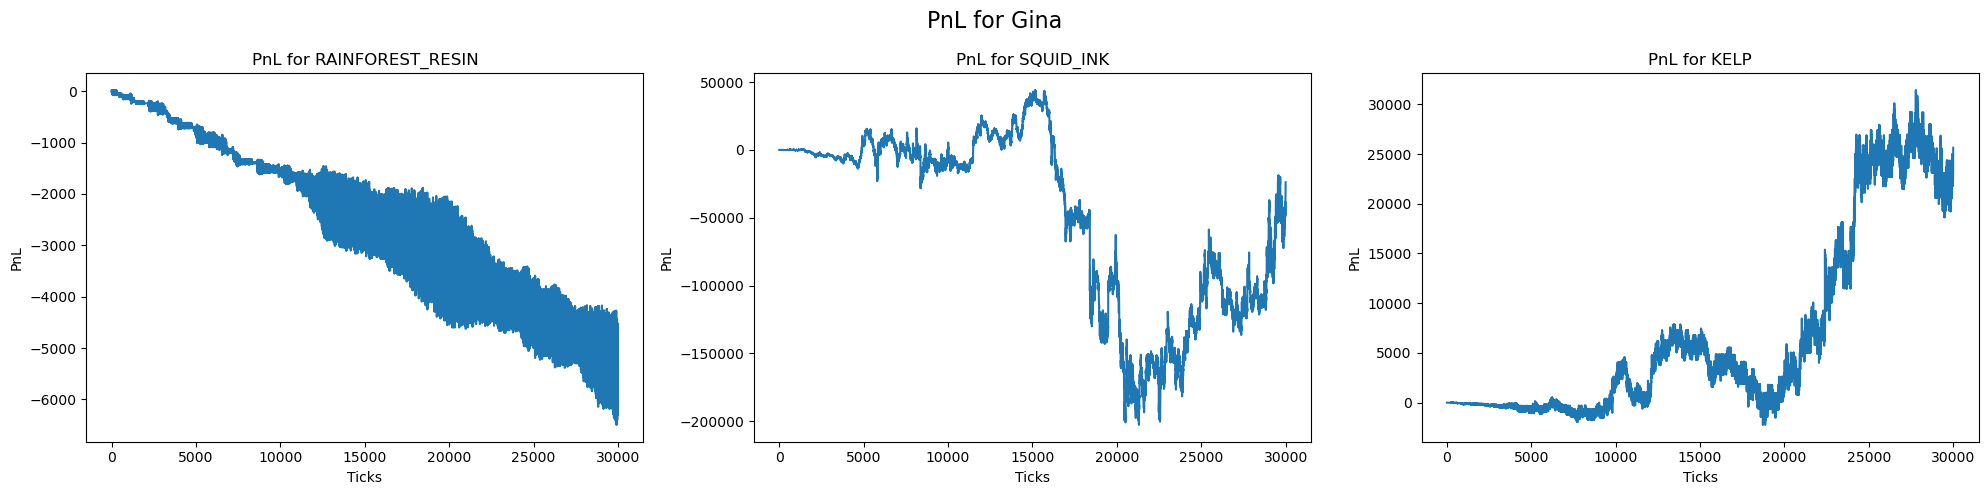

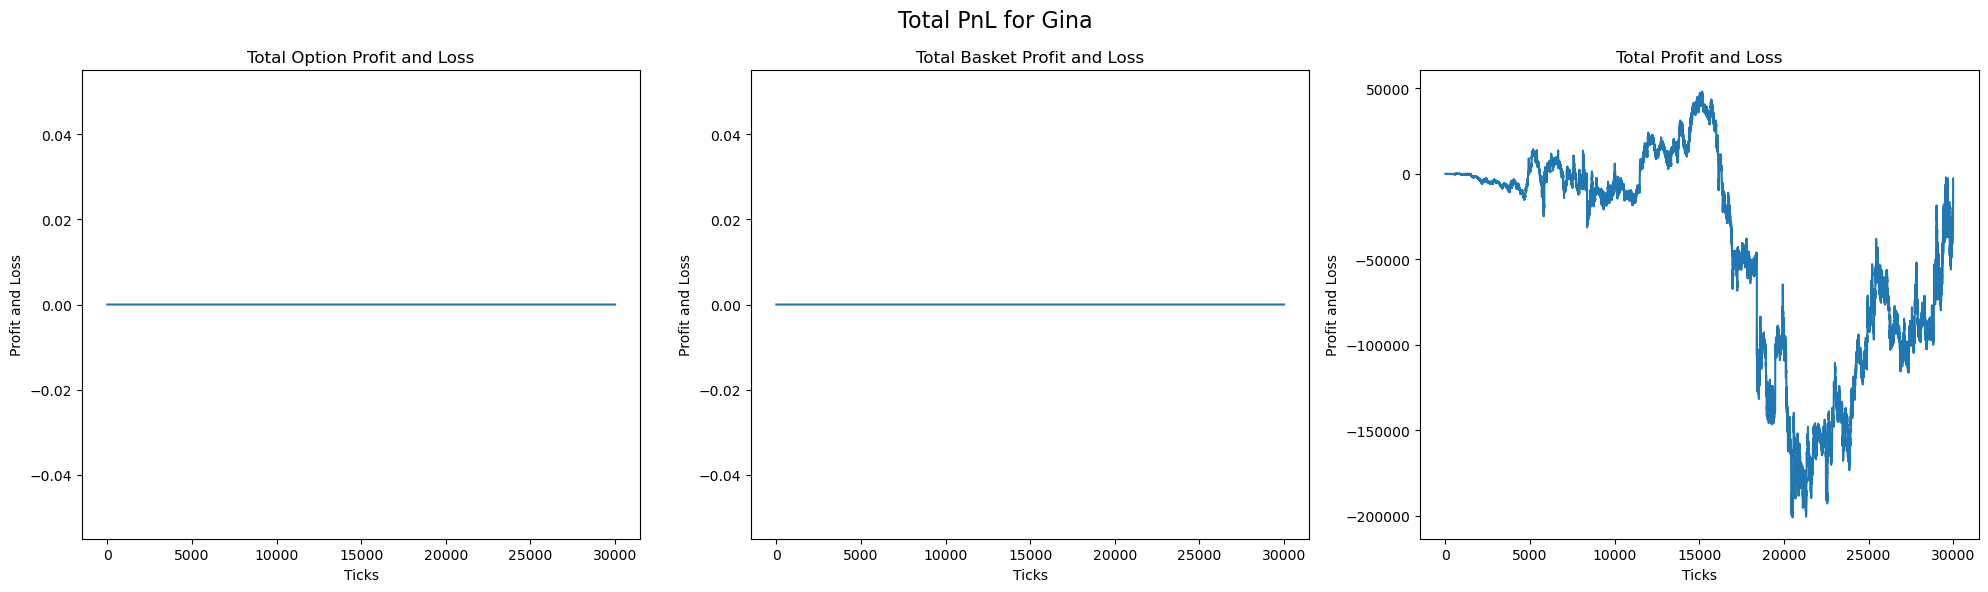

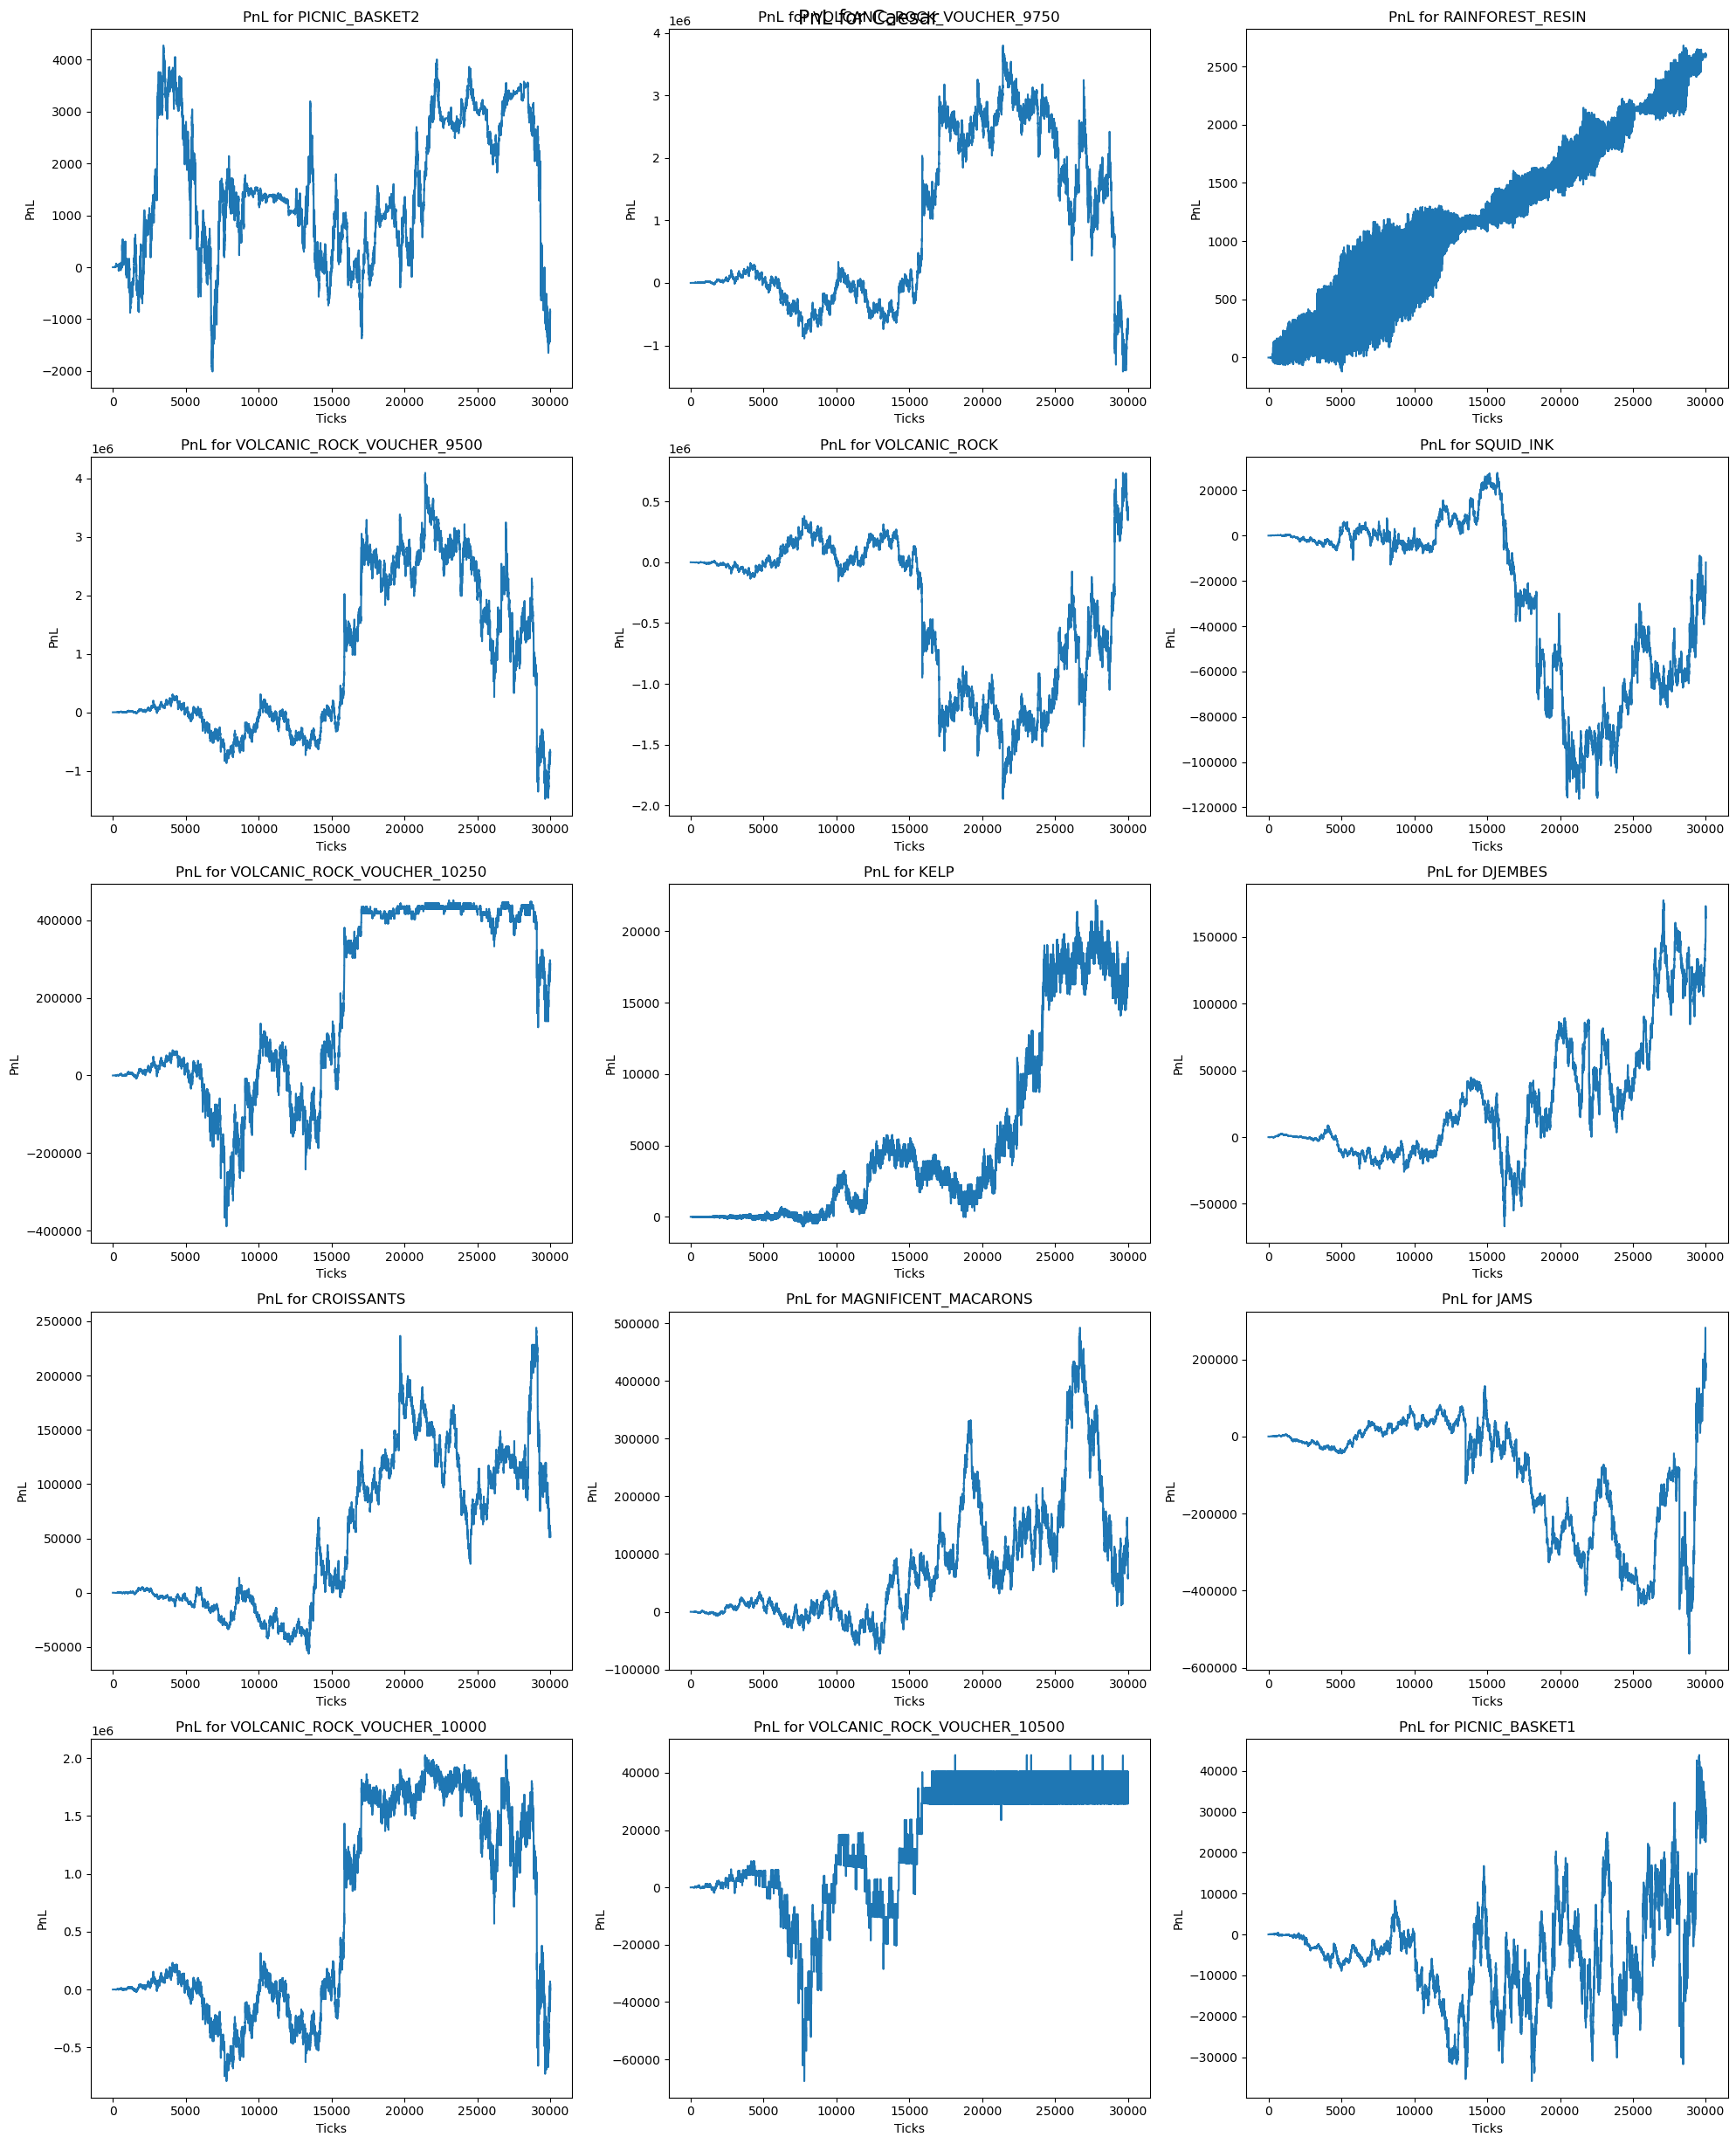

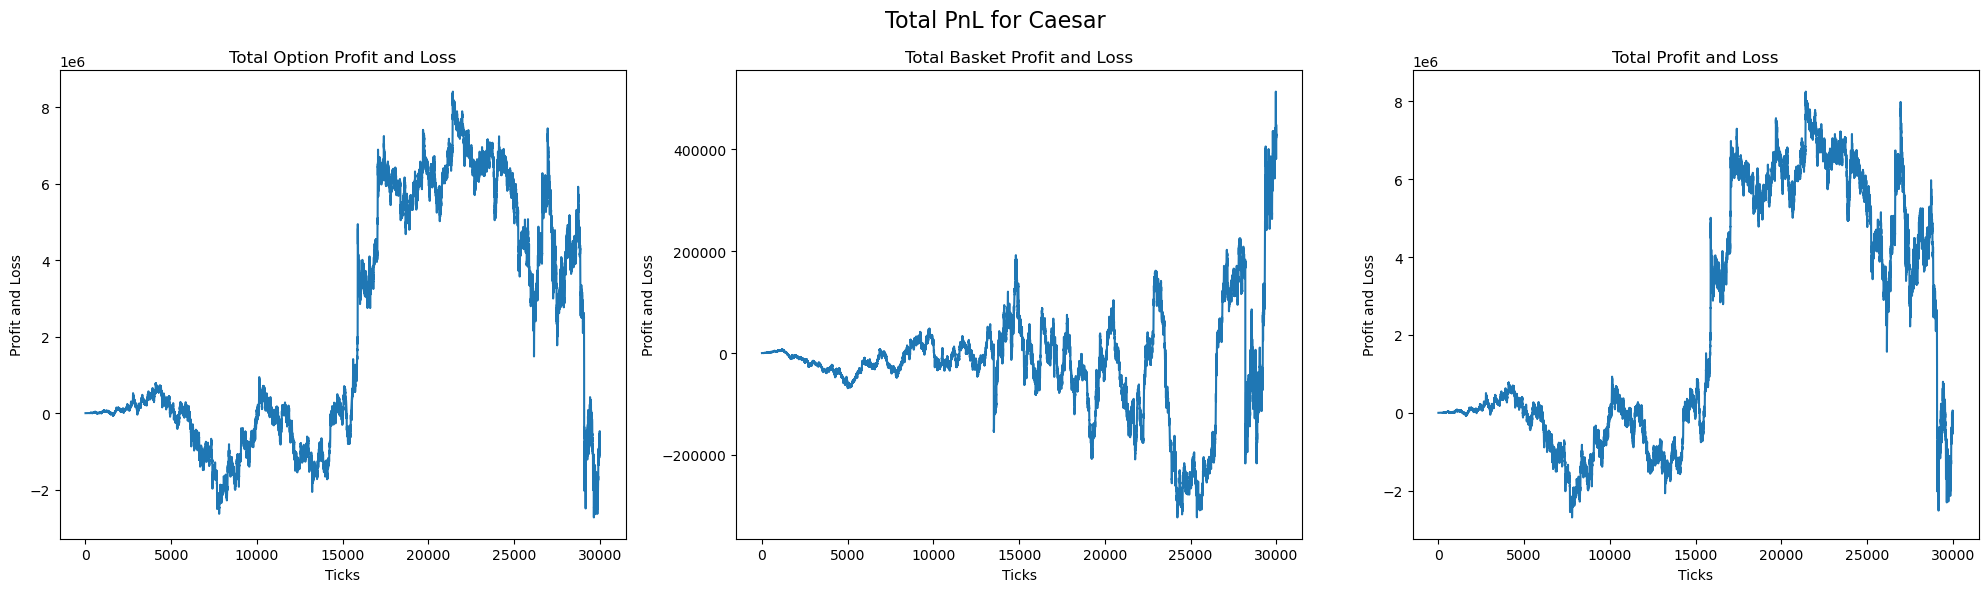

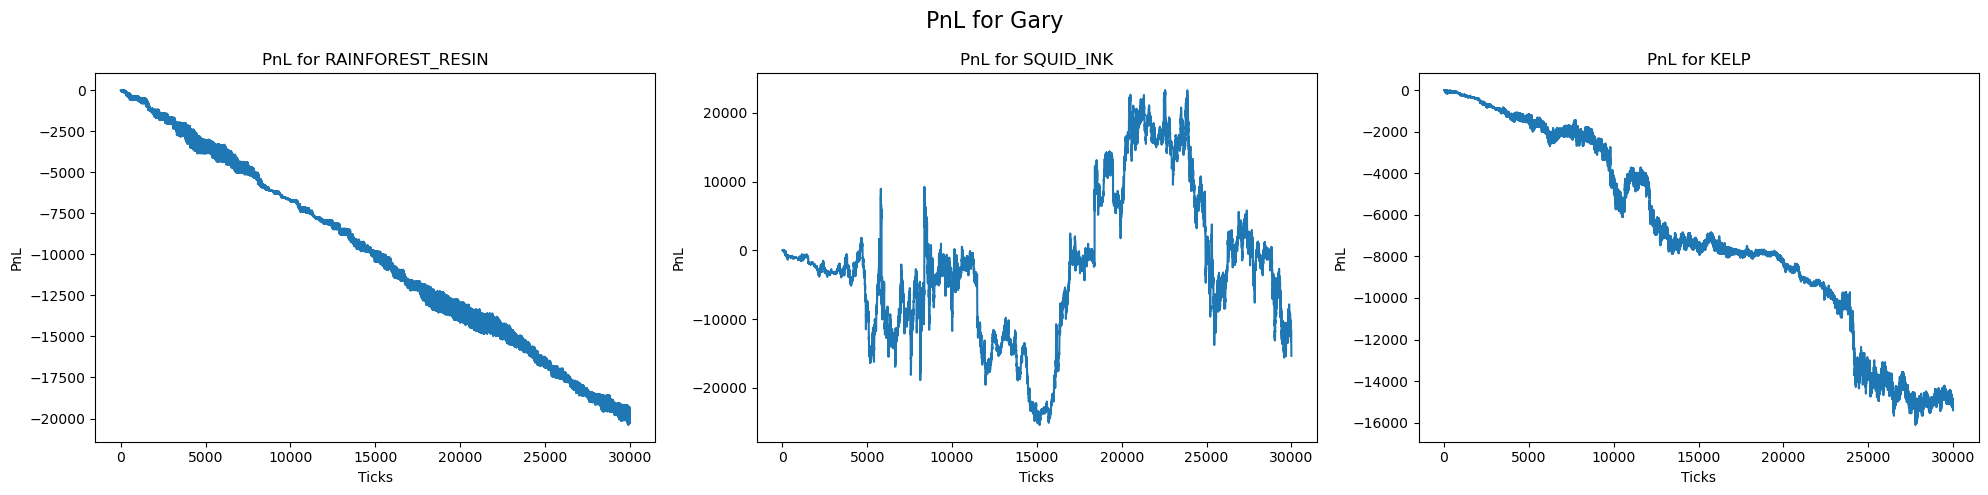

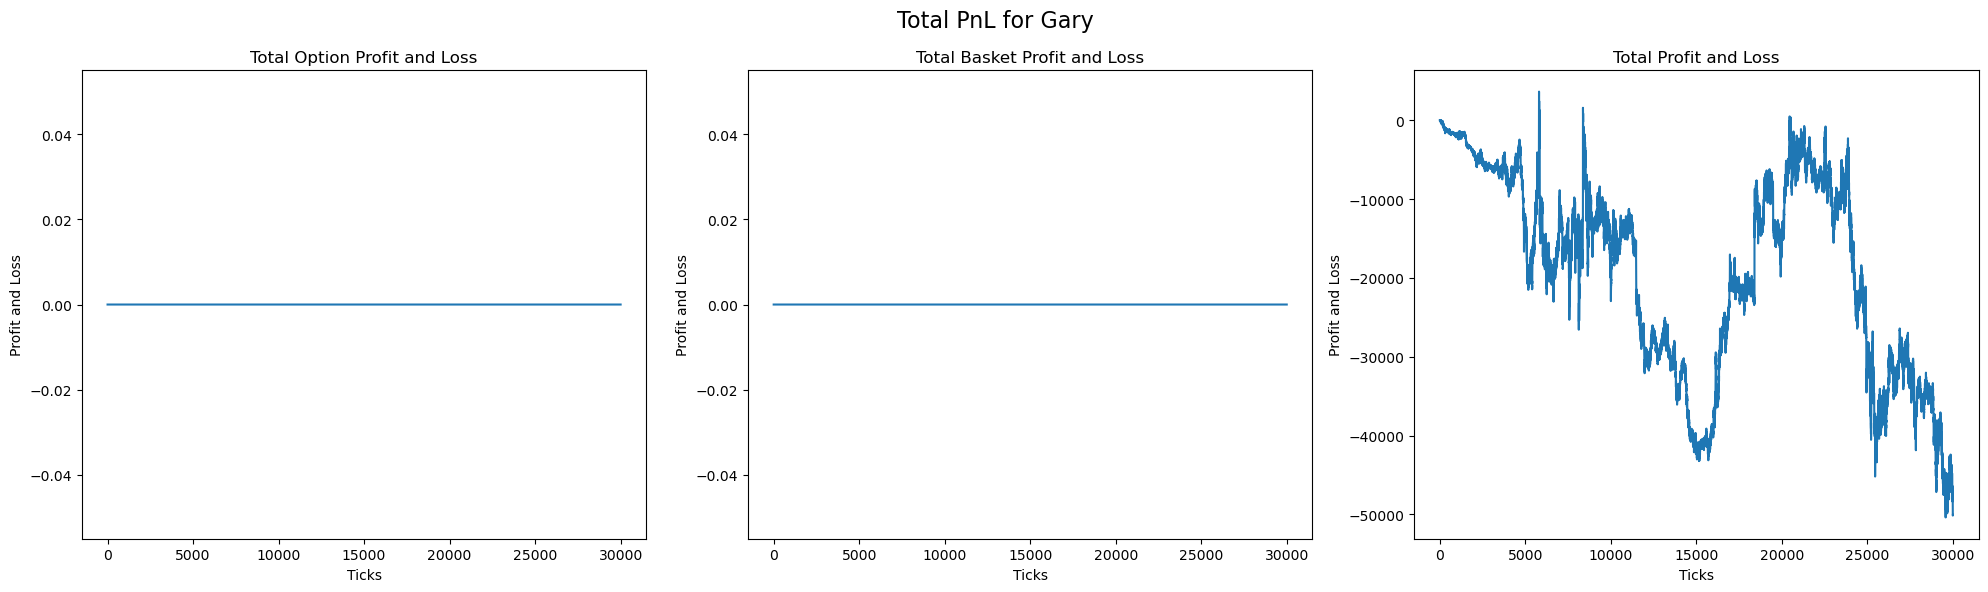

In [222]:
for trader in traders_set:
    snapshot = pd.read_csv(f"./trader_logs/{trader}.csv", sep=";")
    plot_pnl(snapshot, products, trader)

Conclusion:
- Charlie: only trades baskets but not components. Only make for Macarons, baskets. Purely loss on baskets and Macarons. Gamble on inks.
- Olivia: knows the best trading point for Kelp, Croissants and Inks. Olivia aggressively take 3 Croissants (15 inks, 15 kelps) once a day at the highest and lowest price.
- Olga: only trades Kelp.
- 5 takers and 3 makers for resin.

In [248]:
trader_log, snapshot = get_trader_log(trades, prices, "Olivia")

In [249]:
trader_log_c = trader_log[trader_log["product"] == "CROISSANTS"].copy()

In [250]:
trader_log_c

day  timestamp     product  quantity  trade_value   price  position
2     2     201600  CROISSANTS        -3     -12834.0  4278.0        -3
4     2     789900  CROISSANTS         3      12699.0  4233.0         0
7     3     343600  CROISSANTS         3      12681.0  4227.0         3
11    3     971000  CROISSANTS        -3     -12942.0  4314.0         0
14    4     452600  CROISSANTS         3      12792.0  4264.0         3
16    4     903700  CROISSANTS        -3     -12921.0  4307.0         0

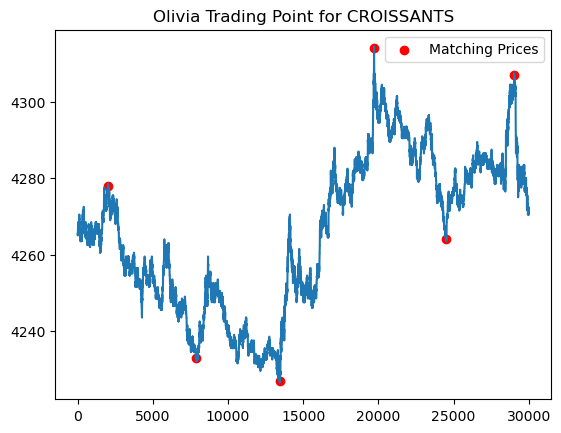

In [252]:
plt.plot(prices[prices["product"] == "CROISSANTS"]["mid_price"].reset_index(drop=True))
snapshot_c = snapshot[snapshot["product"] == "CROISSANTS"].reset_index(drop=True).copy()
snapshot_c = snapshot_c[snapshot_c["price"].notnull()]
plt.scatter(snapshot_c.index, snapshot_c["price"], color='red', label='Matching Prices')
plt.title("Olivia Trading Point for CROISSANTS")
plt.legend()
plt.show()

In [244]:
snapshot_c["maker_flag"].value_counts()

maker_flag
0.0    6
Name: count, dtype: int64

Olivia knows the highest and lowest price of Croissants. Let's see SQUID_INK.

In [245]:
trader_log, snapshot = get_trader_log(trades, prices, "Olivia")
trader_log_s = trader_log[trader_log["product"] == "SQUID_INK"].reset_index(drop=True).copy()
snapshot_s = snapshot[snapshot["product"] == "SQUID_INK"].reset_index(drop=True).copy()
snapshot_s = snapshot_s[snapshot_s["price"].notnull()]

In [247]:
trader_log_s

day  timestamp    product  quantity  trade_value   price  position
0    2     115200  SQUID_INK        15      26580.0  1772.0        15
1    2     580200  SQUID_INK       -15     -28862.0  1925.0         0
2    3     515300  SQUID_INK        15      26430.0  1762.0        15
3    3     928000  SQUID_INK       -15     -29790.0  1986.0         0
4    4      51100  SQUID_INK       -15     -30705.0  2047.0       -15
5    4     957500  SQUID_INK        15      28440.0  1896.0         0

In [255]:
snapshot_s

day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
1152     2     115200  SQUID_INK       1770.0          10.0       1769.0   
5802     2     580200  SQUID_INK       1926.0           1.0       1924.0   
15153    3     515300  SQUID_INK       1760.0           4.0       1759.0   
19280    3     928000  SQUID_INK       1986.0          27.0          NaN   
20511    4      51100  SQUID_INK       2047.0          21.0          NaN   
29575    4     957500  SQUID_INK       1893.0          27.0          NaN   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
1152           26.0          NaN           NaN       1772.0  ...   
5802           30.0          NaN           NaN       1928.0  ...   
15153          30.0          NaN           NaN       1762.0  ...   
19280           NaN          NaN           NaN       1988.0  ...   
20511           NaN          NaN           NaN       2049.0  ...   
29575           NaN          NaN           NaN       1896.0  ...   

       ask_volume_2  ask_price_3  ask_volume_3  mid_price  profit_and_loss  \
1152            NaN          NaN           NaN     1771.0            -15.0   
5802            NaN          NaN           NaN     1927.0           2282.0   
15153           NaN          NaN           NaN     1761.0           2267.0   
19280          27.0          NaN           NaN     1987.0           5642.0   
20511          21.0          NaN           NaN     2048.0           5627.0   
29575           NaN          NaN           NaN     1894.5           7907.0   

       quantity  trade_value   price  position  maker_flag  
1152       15.0      26580.0  1772.0      15.0         0.0  
5802      -15.0     -28862.0  1925.0       0.0         0.0  
15153      15.0      26430.0  1762.0      15.0         0.0  
19280     -15.0     -29790.0  1986.0       0.0         0.0  
20511     -15.0     -30705.0  2047.0     -15.0         0.0  
29575      15.0      28440.0  1896.0       0.0         0.0  

[6 rows x 22 columns]

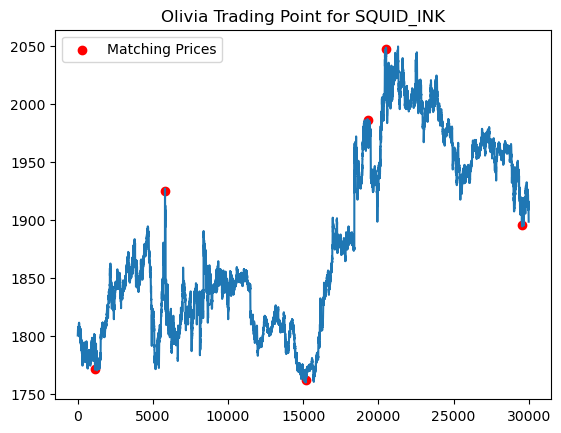

In [254]:
plt.plot(prices[prices["product"] == "SQUID_INK"]["mid_price"].reset_index(drop=True))
plt.scatter(snapshot_s.index, snapshot_s["price"], color='red', label='Matching Prices')
plt.title("Olivia Trading Point for SQUID_INK")
plt.legend()
plt.show()

Then kelp

In [256]:
trader_log, snapshot = get_trader_log(trades, prices, "Olivia")
trader_log_k = trader_log[trader_log["product"] == "KELP"].reset_index(drop=True).copy()
snapshot_k = snapshot[snapshot["product"] == "KELP"].reset_index(drop=True).copy()
snapshot_k = snapshot_k[snapshot_k["price"].notnull()]

In [257]:
trader_log_k

day  timestamp product  quantity  trade_value   price  position
0    2     102400    KELP       -15     -30750.0  2050.0       -15
1    2     980800    KELP        15      30630.0  2042.0         0
2    3     158200    KELP       -15     -30660.0  2044.0       -15
3    3     343800    KELP        15      30480.0  2032.0         0
4    4      77700    KELP       -15     -30555.0  2037.0       -15
5    4     778300    KELP        15      30135.0  2009.0         0

In [258]:
snapshot_k

day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
1024     2     102400    KELP       2050.0          20.0          NaN   
9808     2     980800    KELP       2039.0          28.0          NaN   
11582    3     158200    KELP       2044.0          30.0          NaN   
13438    3     343800    KELP       2029.0           2.0       2028.0   
20777    4      77700    KELP       2037.0          28.0          NaN   
27783    4     778300    KELP       2006.0          28.0          NaN   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  \
1024            NaN          NaN           NaN       2051.0  ...   
9808            NaN          NaN           NaN       2042.0  ...   
11582           NaN          NaN           NaN       2048.0  ...   
13438          20.0          NaN           NaN       2032.0  ...   
20777           NaN          NaN           NaN       2040.0  ...   
27783           NaN          NaN           NaN       2009.0  ...   

       ask_volume_2  ask_price_3  ask_volume_3  mid_price  profit_and_loss  \
1024           21.0          NaN           NaN     2050.5             -7.5   
9808            NaN          NaN           NaN     2040.5            120.0   
11582           NaN          NaN           NaN     2046.0             90.0   
13438           NaN          NaN           NaN     2030.5            300.0   
20777          27.0          NaN           NaN     2038.5            277.5   
27783           NaN          NaN           NaN     2007.5            720.0   

       quantity  trade_value   price  position  maker_flag  
1024      -15.0     -30750.0  2050.0     -15.0         0.0  
9808       15.0      30630.0  2042.0       0.0         0.0  
11582     -15.0     -30660.0  2044.0     -15.0         0.0  
13438      15.0      30480.0  2032.0       0.0         0.0  
20777     -15.0     -30555.0  2037.0     -15.0         0.0  
27783      15.0      30135.0  2009.0       0.0         0.0  

[6 rows x 22 columns]

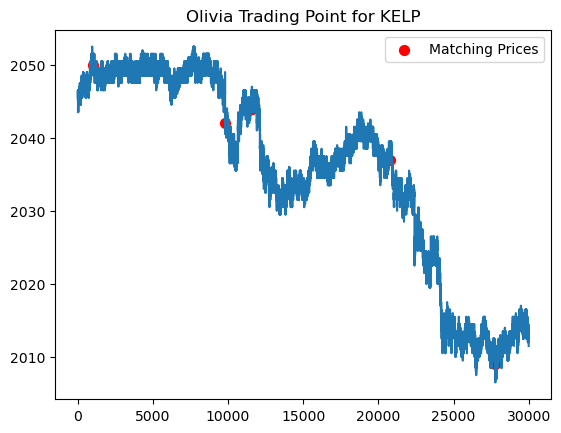

In [265]:
plt.scatter(snapshot_k.index, snapshot_k["price"].values, color='red', label='Matching Prices', s=50)
plt.plot(prices[prices["product"] == "KELP"]["mid_price"].reset_index(drop=True))

plt.title("Olivia Trading Point for KELP")
plt.legend()
plt.show()